In [ ]:
! pip install arch
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


In [ ]:
import os
import math
from scipy.stats import norm
import itertools
from arch import arch_model
from arch.univariate import APARCH, Normal, ZeroMean
from graphviz import Source
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.stattools import (
    acf, pacf, q_stat, adfuller, kpss
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import PhillipsPerron
from scipy.stats import jarque_bera
import numpy as np
import pandas as pd
import scipy.stats as stats
import yfinance as yf
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRFRegressor
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from lightgbm import LGBMRegressor
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRFRegressor
import itertools

In [ ]:
ticker = ['HD']
end_date = '2025-05-07'

df = yf.download(
    ticker,
    interval="1d",
    progress=False,
    end=end_date,
    keepna=False
)
df = df.loc[:, (['Close'], ticker)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df = df.rename(columns={
    'Date': 'ds',
    'HD': 'HDprice'
})
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds').reset_index(drop=True)
df['ret'] = df['HDprice'].pct_change()*100
df.columns.name = 'Ticker'
df.columns.name = None
df = df.rename_axis(columns=None)

YF.download() has changed argument auto_adjust default to True


In [ ]:
df

,ds,HDprice,ret
0,1981-09-22,0.017052,NaN
1,1981-09-23,0.017052,0.000000
2,1981-09-24,0.017052,0.000000
3,1981-09-25,0.017052,0.000000
4,1981-09-28,0.017052,0.000000
...,...,...,...
10990,2025-04-30,360.489990,0.415039
10991,2025-05-01,358.299988,-0.607507
10992,2025-05-02,364.519989,1.735976
10993,2025-05-05,361.730011,-0.765384


In [ ]:
#output_path = "HW3HomeDepot.xlsx"
#df.to_excel(output_path, index=False)

In [ ]:
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'

In [ ]:
def SACF_SPACF(series, lag_max = 19, alpha_level = 0.05, model_df = 0):
    """
    Compute the sample autocorrelation function (SACF), sample partial autocorrelation function (SPACF),
    and Ljung-Box Q-statistics for a time series.

    This function calculates the ACF and PACF values along with their corresponding confidence intervals
    for lags 1 through `lag_max` using the provided significance level (`alpha_level`). In addition, it
    computes the Ljung-Box Q-statistic and associated p-values (excluding lag 0). Set `model_df`
    to the number of dof lost.

    """

    # Calculate ACF and PACF with confidence intervals
    acf_vals, acf_confint = acf(series, nlags=lag_max, alpha=alpha_level)
    pacf_vals, pacf_confint = pacf(series, nlags=lag_max, alpha=alpha_level, method='ols')

    # Calculate Ljung-Box statistics and p-values
    lb_results = sm.stats.acorr_ljungbox(
        series,
        lags=range(1, lag_max + 1),
        model_df=model_df,
        return_df=True
    )

    # Build the results DataFrame
    df_acf_pacf = pd.DataFrame({
        "Lag": np.arange(1, lag_max + 1),
        "ACF": acf_vals[1:],
        "ACF_lower": acf_confint[1:, 0],
        "ACF_upper": acf_confint[1:, 1],
        "PACF": pacf_vals[1:],
        "PACF_lower": pacf_confint[1:, 0],
        "PACF_upper": pacf_confint[1:, 1],
        "Q-stat": lb_results["lb_stat"].values,
        "Q-stat Prob": lb_results["lb_pvalue"].values.round(6)
    })

    # Set the index to 'Lag' and extract the main columns
    df_acf_pacf.set_index("Lag", inplace=True)
    df_acf_pacf_small = df_acf_pacf[["ACF", "PACF", "Q-stat", "Q-stat Prob"]].copy()

    return df_acf_pacf_small

In [ ]:
def SACF_SPACF_plot (series, name, lag_max = 19, ylim = [-0.15, 0.15]):
  """
    Generate plots for the Sample Autocorrelation (SACF) and Sample Partial Autocorrelation (SPACF)
    of a time series.

  """
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  # Sample Autocorrelation (SACF) Plot
  plot_acf(series, lags=19, ax=axes[0], zero=False)
  axes[0].set_title(f"SACF{name}")
  axes[0].set_ylim(ylim)

  # Sample Partial Autocorrelation (SPACF) Plot
  plot_pacf(series, lags=19, ax=axes[1], method='ols', zero=False)
  axes[1].set_title(f"SPACF{name}")
  axes[1].set_ylim(ylim)

  plt.tight_layout()
  return plt.show()

In [ ]:
def SACF_SPACF_plot_wide (series, name, lag_max = 19, ylim = [-0.2, 1.1]):
  """
    Generate plots for the Sample Autocorrelation (SACF) and Sample Partial Autocorrelation (SPACF)
    of a time series.

  """
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  # Sample Autocorrelation (SACF) Plot
  plot_acf(series, lags=19, ax=axes[0], zero=False)
  axes[0].set_title(f"SACF{name}")
  axes[0].set_ylim(ylim)

  # Sample Partial Autocorrelation (SPACF) Plot
  plot_pacf(series, lags=19, ax=axes[1], method='ols', zero=False)
  axes[1].set_title(f"SPACF{name}")
  axes[1].set_ylim(ylim)

  plt.tight_layout()
  return plt.show()

In [ ]:
def unit_root_tests(series, name="Series"):
    """
    Runs multiple unit-root tests on a given Pandas Series:
      1) ADF (autolag=BIC, constant only)
      2) ADF (autolag=BIC, no constant)
      3) ADF (autolag=AIC, constant only)
      4) ADF (exactly 12 lags, constant only)
      5) ADF (autolag=BIC, constant + linear trend)
      6) ADF (autolag=BIC, constant + linear + quadratic trend)
      7) Phillips–Perron (constant only)
      8) KPSS (constant only)
    """

    def format_crit_vals(crit_dict):
      parts = []
      for k, v in crit_dict.items():
          formatted = f"{k}: {v:.4f}"
          parts.append(formatted)
      result = "; ".join(parts)
      return result

    results_list = []

    print(f"\n=== UNIT-ROOT TESTS FOR: {name} ===\n")

    ############################################################################
    # 1) ADF Test (BIC, constant only)
    ############################################################################
    adf_bic = adfuller(series, autolag='BIC', regression='c')
    print("=== ADF Test (BIC, constant only) ===")
    print(f"ADF statistic: {adf_bic[0]:.4f}")
    print(f"p-value:       {adf_bic[1]:.4f}")
    print(f"Lags used:     {adf_bic[2]}")
    print("Critical values:")
    for k, v in adf_bic[4].items():
        print(f"    {k}: {v:.4f}")
    print(f"IC Best (BIC): {adf_bic[5]:.4f}\n")

    results_list.append({
        "Test": "ADF (BIC, c)",
        "ADF stat": adf_bic[0],
        "p-value": adf_bic[1],
        "Lags used": adf_bic[2],
        "IC Best": adf_bic[5],
        "Critical values": format_crit_vals(adf_bic[4])
    })

    ############################################################################
    # 2) ADF Test (BIC, no constant)
    ############################################################################
    adf_bic_nc = adfuller(series, autolag='BIC', regression='n')
    print("=== ADF Test (BIC, no constant) ===")
    print(f"ADF statistic: {adf_bic_nc[0]:.4f}")
    print(f"p-value:       {adf_bic_nc[1]:.4f}")
    print(f"Lags used:     {adf_bic_nc[2]}")
    print("Critical values:")
    for k, v in adf_bic[4].items():
        print(f"    {k}: {v:.4f}")
    print(f"IC Best (BIC): {adf_bic[5]:.4f}\n")

    results_list.append({
        "Test": "ADF (BIC, nc)",
        "ADF stat": adf_bic_nc[0],
        "p-value": adf_bic_nc[1],
        "Lags used": adf_bic_nc[2],
        "IC Best": adf_bic_nc[5],
        "Critical values": format_crit_vals(adf_bic_nc[4])
    })

    ############################################################################
    # 3) ADF Test (AIC, constant only)
    ############################################################################
    adf_aic = adfuller(series, autolag='AIC', regression='c')
    print("=== ADF Test (AIC, constant only) ===")
    print(f"ADF statistic: {adf_aic[0]:.4f}")
    print(f"p-value:       {adf_aic[1]:.4f}")
    print(f"Lags used:     {adf_aic[2]}")
    print("Critical values:")
    for k, v in adf_aic[4].items():
        print(f"    {k}: {v:.4f}")
    print(f"IC Best (AIC): {adf_aic[5]:.4f}\n")

    results_list.append({
        "Test": "ADF (AIC, c)",
        "ADF stat": adf_aic[0],
        "p-value": adf_aic[1],
        "Lags used": adf_aic[2],
        "IC Best": adf_aic[5],
        "Critical values": format_crit_vals(adf_aic[4])
    })

    ############################################################################
    # 4) ADF Test (exactly 12 lags, constant only)
    ############################################################################
    adf_12 = adfuller(series, maxlag=12, autolag=None, regression='c')
    print("=== ADF Test (exactly 12 lags, constant only) ===")
    print(f"ADF statistic: {adf_12[0]:.4f}")
    print(f"p-value:       {adf_12[1]:.4f}")
    print(f"Lags used:     {adf_12[2]}")
    print("Critical values:")
    for k, v in adf_12[4].items():
        print(f"    {k}: {v:.4f}")
    print()

    results_list.append({
        "Test": "ADF (10 lags, c)",
        "ADF stat": adf_12[0],
        "p-value": adf_12[1],
        "Lags used": adf_12[2],
        "IC Best": None,
        "Critical values": format_crit_vals(adf_12[4])
    })

    ############################################################################
    # 5) ADF Test (BIC, constant + linear trend)
    ############################################################################
    adf_trend_l = adfuller(series, autolag='BIC', regression='ct')
    print("=== ADF Test (BIC, constant + linear trend) ===")
    print(f"ADF statistic: {adf_trend_l[0]:.4f}")
    print(f"p-value:       {adf_trend_l[1]:.4f}")
    print(f"Lags used:     {adf_trend_l[2]}")
    print("Critical values:")
    for k, v in adf_trend_l[4].items():
        print(f"    {k}: {v:.4f}")
    print(f"IC Best (BIC): {adf_trend_l[5]:.4f}\n")

    results_list.append({
        "Test": "ADF (BIC, c+t)",
        "ADF stat": adf_trend_l[0],
        "p-value": adf_trend_l[1],
        "Lags used": adf_trend_l[2],
        "IC Best": adf_trend_l[5],
        "Critical values": format_crit_vals(adf_trend_l[4])
    })

    ############################################################################
    # 6) ADF Test (BIC, constant + linear + quadratic trend)
    ############################################################################
    adf_trend_q = adfuller(series, autolag='BIC', regression='ctt')
    print("=== ADF Test (BIC, constant + linear + quadratic trend) ===")
    print(f"ADF statistic: {adf_trend_q[0]:.4f}")
    print(f"p-value:       {adf_trend_q[1]:.4f}")
    print(f"Lags used:     {adf_trend_q[2]}")
    print("Critical values:")
    for k, v in adf_trend_q[4].items():
        print(f"    {k}: {v:.4f}")
    print(f"IC Best (BIC): {adf_trend_q[5]:.4f}")

    results_list.append({
        "Test": "ADF (BIC, c+t+q)",
        "ADF stat": adf_trend_q[0],
        "p-value": adf_trend_q[1],
        "Lags used": adf_trend_q[2],
        "IC Best": adf_trend_q[5],
        "Critical values": format_crit_vals(adf_trend_q[4])
    })

    print()

    ############################################################################
    # 7) Phillips–Perron Test (constant only)
    ############################################################################
    pp_test = PhillipsPerron(series, trend='c')
    print("=== Phillips–Perron Test ===")
    print(f"PP Statistic: {pp_test.stat:.4f}")
    print(f"p-value:      {pp_test.pvalue:.4f}")
    print("Critical values:")
    # 'critical_values' is a dict
    for k, v in pp_test.critical_values.items():
        print(f"    {k}: {v:.4f}")

    results_list.append({
        "Test": "Phillips–Perron (c)",
        "ADF stat": pp_test.stat,
        "p-value": pp_test.pvalue,
        "Lags used": None,
        "IC Best": None,
        "Critical values": format_crit_vals(pp_test.critical_values)
    })

    print()

    ############################################################################
    # 8) KPSS Test (constant only)
    ############################################################################
    kpss_stat, kpss_pvalue, kpss_lags, kpss_critvals = kpss(series, regression='c')
    print("=== KPSS Test ===")
    print(f"Test Statistic: {kpss_stat:.4f}")
    print(f"p-value:        {kpss_pvalue:.4f}")
    print(f"Lags used:      {kpss_lags}")
    print("Critical Values:", kpss_critvals)
    print()

    results_list.append({
        "Test": "KPSS (c)",
        "ADF stat": kpss_stat,
        "p-value": kpss_pvalue,
        "Lags used": kpss_lags,
        "IC Best": None,
        "Critical values": format_crit_vals(kpss_critvals)
    })

    results_df = pd.DataFrame(results_list)

    return results_df

Question 1

In [ ]:
fig_price = go.Figure()
fig_price.add_trace(go.Scatter(
    x=df["ds"], y=df['HDprice'],
    mode='lines',
    name='Price',
    line=dict(color='blue', width=1.5),
))
fig_price.update_layout(
    title=dict(
        text='HD Price',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False
    ),
    yaxis=dict(
        title='HD Price',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False,
        zeroline=False
    ),
    font=dict(
        family="Serif",
        size=25,
        color="black"
    ),
)

fig_price.show()

In [ ]:
df["HDprice"].describe()

,HDprice
count,10995.000000
mean,63.723844
std,98.864100
min,0.017052
25%,4.742000
50%,21.537977
75%,62.683491
max,428.649750


The price series is clearly non-stationary. If it were to be stationary, the observations would fluctuate around a mean value with deviations that after some time revert. Here we clearly see that the price process looks like a random walk, in which the price continues to grow with drift mu plus a random shock. Indeed price processes (continuous time) are described by dS=mu*S*dt+sigma*S*dW(t) meaning that the price is driven by a geometric brownian motion that introduces a determinsitc and stochastic part, hence we have the Random Walk. To make it statioanry we would have to take the first difference of the price level in discrete time or dSt/St in continuous.

Question 2

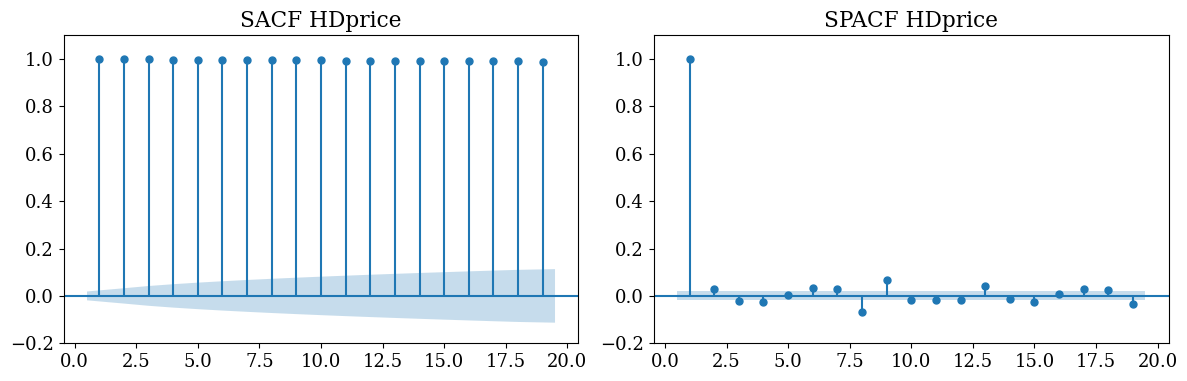

In [ ]:
price=df['HDprice'].values
df_ACP=SACF_SPACF(price)
SACF_SPACF_plot_wide(price," HDprice")

The correlogram confirms our previous intuition, showing that the memory is indeed never fading in the price process and past shocks are remembered forever. This is clearly highlighted by the SACF which shows the autocorrelation between Pt and the various Pt-h. The SACF tells us how much memory is retained, as it is a random walk we would expect it to be 1 and the plot seems to confirm our expectations. The SPACF shows instead the partial autocrrelation. The fact that it is low except at lag 1 confirms our view that we could achieve stationarity by differentiating the process once, as once we control for t-1 all the other t-h lags have little power.

Question 3

In [ ]:
unit_root_df_P = unit_root_tests(df['HDprice'],"Home Depot Price")


=== UNIT-ROOT TESTS FOR: Home Depot Price ===

=== ADF Test (BIC, constant only) ===
ADF statistic: 1.4416
p-value:       0.9973
Lags used:     8
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 43991.4256

=== ADF Test (BIC, no constant) ===
ADF statistic: 2.2915
p-value:       0.9960
Lags used:     8
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 43991.4256

=== ADF Test (AIC, constant only) ===
ADF statistic: 1.5804
p-value:       0.9978
Lags used:     39
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (AIC): 43808.4213

=== ADF Test (exactly 12 lags, constant only) ===
ADF statistic: 1.3976
p-value:       0.9971
Lags used:     12
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669

=== ADF Test (BIC, constant + linear trend) ===
ADF statistic: -0.4592
p-value:       0.9850
Lags used:     8
Critical values:
    1%: -3.9596
    5%: -3.4109
    10%: -3.1273
IC Best (BIC): 43997.5

<ipython-input-10-301e477636bf>:186: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
df_differenced=df.copy()
df_differenced["difference of P"]=(df_differenced["HDprice"])-(df_differenced["HDprice"].shift(1))
df_differenced.dropna(inplace=True)
df_differenced.tail()

,ds,HDprice,ret,difference of P
10990,2025-04-30,360.489990,0.415039,1.489990
10991,2025-05-01,358.299988,-0.607507,-2.190002
10992,2025-05-02,364.519989,1.735976,6.220001
10993,2025-05-05,361.730011,-0.765384,-2.789978
10994,2025-05-06,359.380005,-0.649657,-2.350006


In [ ]:
unit_root_df_Pdif = unit_root_tests(df_differenced['difference of P'],"HD Differenced once")


=== UNIT-ROOT TESTS FOR: HD Differenced once ===

=== ADF Test (BIC, constant only) ===
ADF statistic: -38.6152
p-value:       0.0000
Lags used:     7
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 43981.1816

=== ADF Test (BIC, no constant) ===
ADF statistic: -38.5584
p-value:       0.0000
Lags used:     7
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 43981.1816

=== ADF Test (AIC, constant only) ===
ADF statistic: -18.7589
p-value:       0.0000
Lags used:     39
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (AIC): 43777.9352

=== ADF Test (exactly 12 lags, constant only) ===
ADF statistic: -29.2913
p-value:       0.0000
Lags used:     12
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669

=== ADF Test (BIC, constant + linear trend) ===
ADF statistic: -38.6871
p-value:       0.0000
Lags used:     7
Critical values:
    1%: -3.9596
    5%: -3.4109
    10%: -3.1273
IC Best (B

To asses the stationarity of the HD price series we conducted the ADF, PP and KPSS tests. Both the ADF and PP tests exhibited p-values close to 1 (only one was 0.46), failing to reject the null of non-stationarity. The KPSS had p-value of 1%, we thus reject the null of stationarity stregthening our results. After assessing that the series is stationary, we differentiated it once and run the same tests to check whether it is an I(1) process. We reject non-stationarity with the ADF and PP tests and we fail to reject stationarity in the KPSS test with confidence level 1% . We can conclude the series is I(1).









Question 4

In [ ]:
df["ret"].describe()

,ret
count,10994.000000
mean,0.116685
std,2.284059
min,-28.735682
25%,-0.900920
50%,0.000000
75%,1.068901
max,32.928733


In [ ]:
df

,ds,HDprice,ret
0,1981-09-22,0.017052,NaN
1,1981-09-23,0.017052,0.000000
2,1981-09-24,0.017052,0.000000
3,1981-09-25,0.017052,0.000000
4,1981-09-28,0.017052,0.000000
...,...,...,...
10990,2025-04-30,360.489990,0.415039
10991,2025-05-01,358.299988,-0.607507
10992,2025-05-02,364.519989,1.735976
10993,2025-05-05,361.730011,-0.765384


In [ ]:
fig_ret = go.Figure()
fig_ret.add_trace(go.Scatter(
    x=df["ds"], y=df['ret'],
    mode='lines',
    name='Return',
    line=dict(color='blue', width=1.5),
))
fig_ret.update_layout(
    title=dict(
        text='Return',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False
    ),
    yaxis=dict(
        title='HD return',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False,
        zeroline=False
    ),
    font=dict(
        family="Serif",
        size=25,
        color="black"
    ),
)

fig_ret.show()

In [ ]:
df["ret"].isna()

,ret
0,True
1,False
2,False
3,False
4,False
...,...
10990,False
10991,False
10992,False
10993,False


In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
unit_root_df_P = unit_root_tests(df['ret'])


=== UNIT-ROOT TESTS FOR: Series ===

=== ADF Test (BIC, constant only) ===
ADF statistic: -103.7008
p-value:       0.0000
Lags used:     0
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 48687.3336

=== ADF Test (BIC, no constant) ===
ADF statistic: -103.4388
p-value:       0.0000
Lags used:     0
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (BIC): 48687.3336

=== ADF Test (AIC, constant only) ===
ADF statistic: -31.9407
p-value:       0.0000
Lags used:     11
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
IC Best (AIC): 48629.5818

=== ADF Test (exactly 12 lags, constant only) ===
ADF statistic: -30.2189
p-value:       0.0000
Lags used:     12
Critical values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669

=== ADF Test (BIC, constant + linear trend) ===
ADF statistic: -103.7814
p-value:       0.0000
Lags used:     0
Critical values:
    1%: -3.9596
    5%: -3.4109
    10%: -3.1273
IC Best (BIC): 48689

<ipython-input-10-301e477636bf>:186: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Even without performing any test the series appears stationary. However, periods of significant volatility can be noticed in the early days of trading and in correspondence of the dotcom bubble and again during the GFC and covid years. To check formally for stationarity we performed again the ADF, PP and KPSS tests. We reject the null of non-stastionarity in the first two tests, with p-values around 0. The KPSS test exhibits p-value of 1%, hence rejecting the null of stationarity. Despite this last controversial result, we believe that looking at the plot and the results of the first 2 tests we can say the series is stationary.

Q5

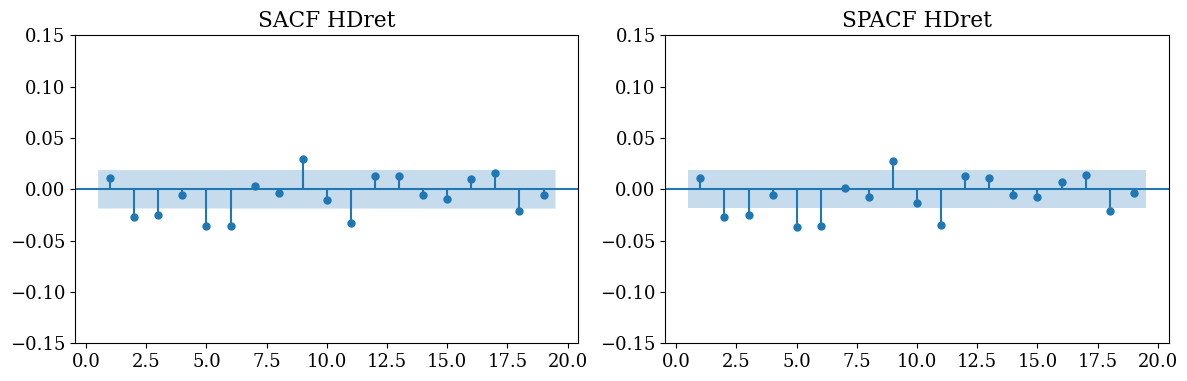

In [ ]:
ret=df['ret'].values
df_ACP=SACF_SPACF(ret)
SACF_SPACF_plot(ret," HDret")

The SACF and PACF plots show significant spikes up to lag 6 with reduced significance beyond that (besides some exceptions). The similarity in the behavior of the SACF and the SPACF makes us believe ARMA model is appropriate. More specifically, we propose an ARMA(6,6) due to the significance up to that lag and because despite the higher complexity, it could effectively capture the structure displayed by the plots. As alternative models, we propose an AR(6), which assumes the current value depends on its past six values, consistent with the SPACF behavior. Similarly, the MA(6) model assumes that the series is driven by shocks over the past six periods, as suggested by the SACF pattern. Lastly, the sinusoidal behavior suggests the presence of complex roots.


Question 6

In [ ]:
df.head()

,ds,HDprice,ret
0,1981-09-23,0.017052,0.0
1,1981-09-24,0.017052,0.0
2,1981-09-25,0.017052,0.0
3,1981-09-28,0.017052,0.0
4,1981-09-29,0.017052,0.0


In [ ]:
best_aic = np.inf
best_order = None
aic_values = {}
#df_ret['ds'] = pd.to_datetime(df['ds'])
#df_ret.set_index('ds',inplace=True)
# Loop through all combinations of p and q from 0 to 4
orders_to_test = [
    (0, 6), # MA(6)
    (6, 0), # AR(6)
    (6, 6)  # ARMA(6,6)
]
for p, q in orders_to_test:
        try:
            # Fit the ARMA model with the given p and q
            model = SARIMAX(df["ret"].values, order=(p, 0, q),trend='c',enforce_stationarity=False,enforce_invertibility=False)  # We assume d=0 for simplicity
            results = model.fit(method='powell')

            # Store AIC and model order
            aic_values[(p, q)] = results.aic

            # Check if we have found a better AIC value
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)

        except Exception as e:
            # Handle cases where fitting the model fails
            print(f"Could not fit ARMA({p}, 0, {q}): {e}")
            continue

# Output the results
print(f"Best ARMA model: ARMA{best_order} with AIC: {best_aic:.2f}")

# Print AIC values for each model
for order, aic_val in aic_values.items():
    print(f"Order: ARMA{order} → AIC: {aic_val:.2f}")

Optimization terminated successfully.
         Current function value: 2.241611
         Iterations: 1
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 2.241815
         Iterations: 1
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: 2.240742
         Iterations: 2
         Function evaluations: 274
Best ARMA model: ARMA(6, 6) with AIC: 49297.43
Order: ARMA(0, 6) → AIC: 49304.54
Order: ARMA(6, 0) → AIC: 49309.03
Order: ARMA(6, 6) → AIC: 49297.43


In [ ]:
model = sm.tsa.statespace.SARIMAX(
    df['ret'].values,
    order=(6, 0, 6),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)

cond_mean_model= model.fit(method = 'powell')
print(cond_mean_model.summary())

Optimization terminated successfully.
         Current function value: 2.240742
         Iterations: 2
         Function evaluations: 274
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10994
Model:               SARIMAX(6, 0, 6)   Log Likelihood              -24634.717
Date:                Tue, 13 May 2025   AIC                          49297.433
Time:                        13:31:58   BIC                          49399.696
Sample:                             0   HQIC                         49331.887
                              - 10994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1668      0.045      3.730      0.000       0.079      

The estimation of our models, looking at the AIC, points towards the selection of the ARMA(6,6). It is important to mention that using the default optimizer, Limited-memory BFGS with Box constraints, yielded convergence warings for any model above order 2. We believed that a higher-order model would have suited our data better. Therefore, we used the Powell optimizer, a derivative-free optimization technique that can perform better when the objective function is complex/noisy. It might find a better optimum in a wider parameter space, potentially leading to a lower likelihood (better fit). In this way, we estimated our models from point 5 and selected the ARMA(6,6) based on the lowest AIC.

Question 7

In [ ]:
resid_df = pd.DataFrame(cond_mean_model.resid)
resid_dfsq=pd.DataFrame(cond_mean_model.resid)**2
df['residsq']=resid_dfsq
df['resid']=resid_df
#resid_df.drop(columns=[0],inplace=True)
#resid_dfsq.drop(columns=[0],inplace=True
#resid_dfsq.drop(columns=[0],inplace=True)
#resid_df.drop(columns=[0],inplace=True)
df


,ds,HDprice,ret,residsq,resid
0,1981-09-23,0.017052,0.000000,0.000000,0.000000
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824
...,...,...,...,...,...
10989,2025-04-30,360.489990,0.415039,0.148037,0.384756
10990,2025-05-01,358.299988,-0.607507,0.551222,-0.742443
10991,2025-05-02,364.519989,1.735976,2.955910,1.719276
10992,2025-05-05,361.730011,-0.765384,1.023292,-1.011579


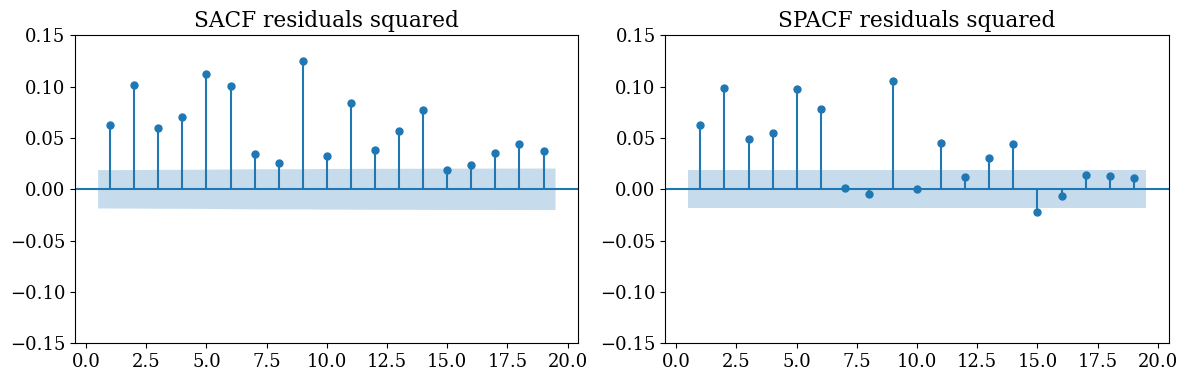

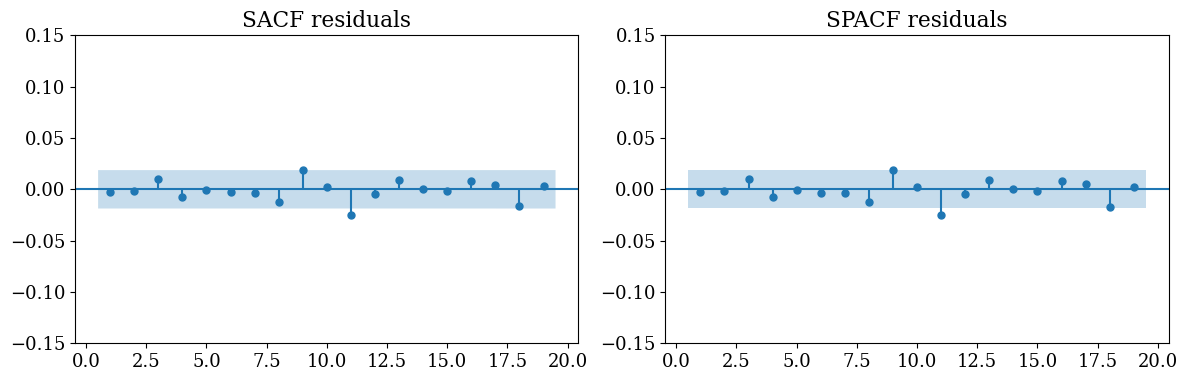

In [ ]:
SACF_SPACF_plot(df["residsq"]," residuals squared")
SACF_SPACF_plot(df["resid"]," residuals")

The resdiuals of our ARMA(6,6) appear not to show any trend. Looking at their SACF and SPACF we see how almost all observations fall within the confidence interval (with a breach at lag 11 probably by chance) . However the squared residuals clearly depart from the previous findings given the high number of significant lags. Particularly, looking at both the SACF and SPACF we clearly see that they move in a cyclical fashion, sign of autocorrelation in the residuals. The variance of residuals is clearly not constant over time, indicating presence of heteroskedasticity. We believe that an ARCH- or GARCH-type model can be used to remove the structure. A way to formally test the presence of ARCH consists in the Lagrange Multiplier test, consisting in regressing the residuals on their own m lags and a constant. Subsequently jointly test that the m coefficients of the lagged residuals are zero. If rejected, we have ARCH.

Question 8

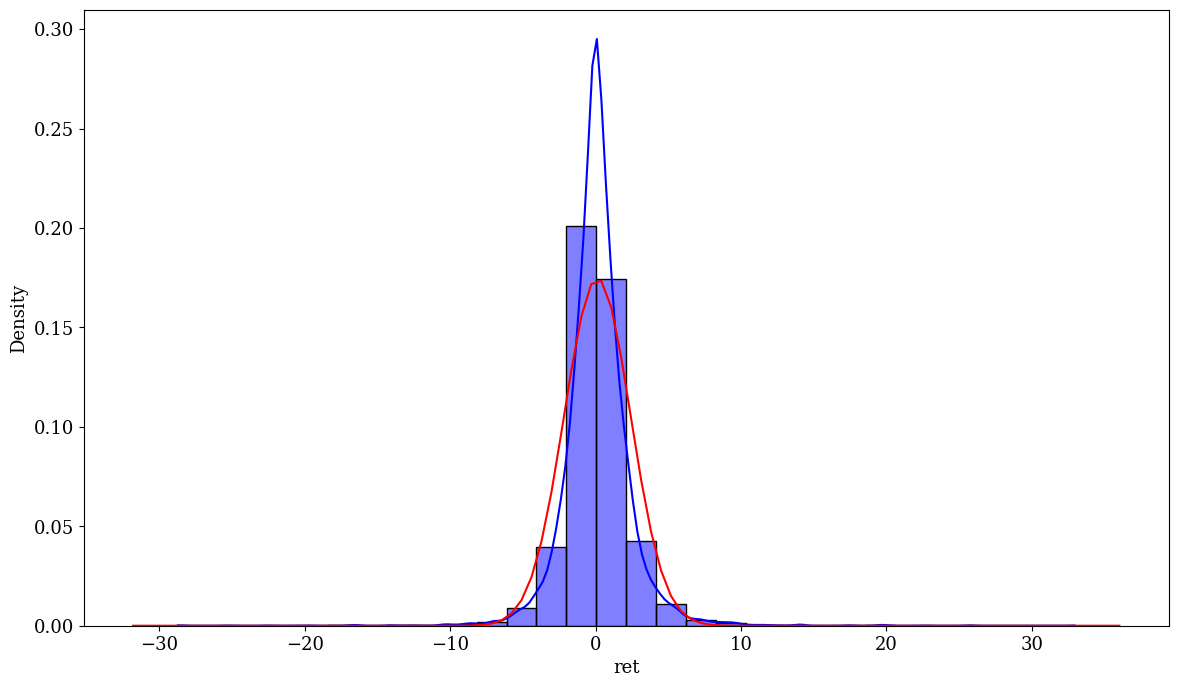

In [ ]:
mean = df['ret'].mean()
std = df['ret'].std()
plt.figure(figsize=(14, 8))
sns.histplot(df['ret'], kde=True, stat='density', color='blue', bins=30, label='Histogram and KDE')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
theoretical_pdf = norm.pdf(x, mean, std)
plt.plot(x, theoretical_pdf, 'r-', label=f'Theoretical Gaussian\n(mean={mean:.2f}, std={std:.2f})')

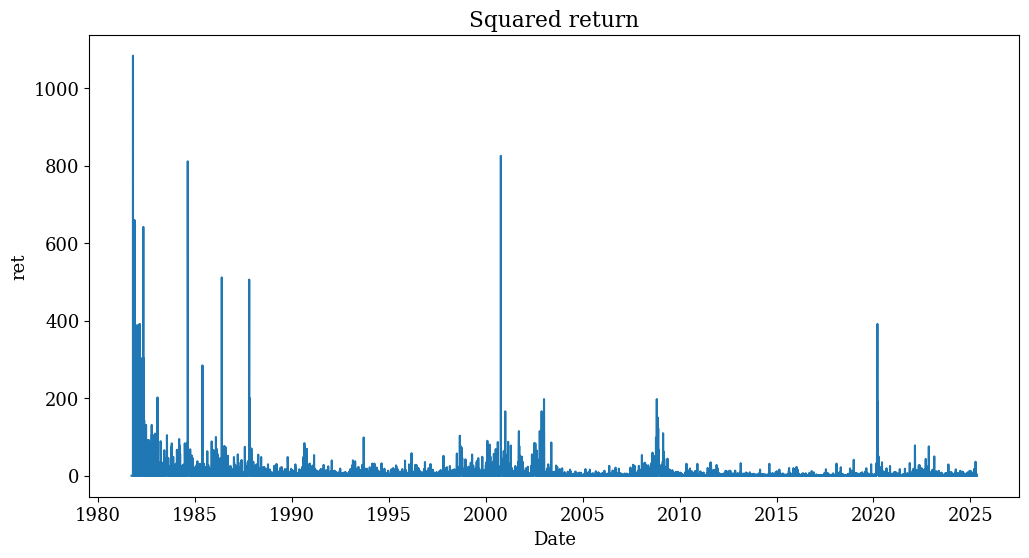

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df['ds'], y=df['ret']**2)
plt.tick_params(labelbottom=True)
plt.xlabel("Date")
plt.title("Squared return")
plt.show()

Looking at the histogram from our ret series, we can clearly see that it departs from Gaussianity. The series is more concentrated around the mean, with high peak and slightly fatter tails that the Gaussian distribution. This is a leptokurtic kind of behavior. Moreover, we can see how the distribution looks fairly symmetric, indicating that the skewness does not depart significantly from the Gaussian one. Looking at the squared returns helps us spot volatility clustering, where periods of high volatility tend to be followed by high volatility. This pattern is visible around major economic and geopolitical shocks such as the 2008 Global Financial Crisis and Covid-19. This is strictly connected to leptokurticity. In fact, periods of very high volatility produce extreme returns that are highlighted in the histogram by the fatter tails. Volatility clustering suggests that returns are conditionally heteroskedastic (their variance changes over time). If the conditional variance σ_t^2 follows a stochastic process rather than being constant, then the unconditional distribution of returns becomes a mixture of distributions with different variances. This mixture naturally leads to excess kurtosis (>3) and fat tails. Due to Jensen’s inequality, when squaring a random variance process, we obtain E(σ_t^4)>[E(σ_t^2)]^2, reinforcing the presence of heavy-tailed distributions. Thus, fat tails in the return distribution are not an anomaly but rather a natural consequence of time-varying volatility and the randomness of conditional variance.

In [ ]:
df

,ds,HDprice,ret,residsq,resid
0,1981-09-23,0.017052,0.000000,0.000000,0.000000
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824
...,...,...,...,...,...
10989,2025-04-30,360.489990,0.415039,0.148037,0.384756
10990,2025-05-01,358.299988,-0.607507,0.551222,-0.742443
10991,2025-05-02,364.519989,1.735976,2.955910,1.719276
10992,2025-05-05,361.730011,-0.765384,1.023292,-1.011579


In [ ]:
df.loc[df["ds"]=="2020-03-16"]

,ds,HDprice,ret,residsq,resid
9701,2020-03-16,146.285217,-19.793817,430.297435,-20.743612


Question 9

In [ ]:
df = df.dropna().reset_index(drop=True)
egarch_df = df.copy()
egarch_df.reset_index(inplace=True)
egarch = arch_model(
    df["resid"],  # Use your pre-calculated residuals here
    mean="Zero",        # No need for mean modeling as residuals should have zero mean
    vol='EGARCH',
    p=3,
    o=3,
    q=2,
    dist='normal'
)
results_egarch = egarch.fit()
epsilons_egarch = results_egarch.resid
epsilons_egarch_squared = epsilons_egarch**2
predicted_egarch_volatility = results_egarch.conditional_volatility
predicted_egarch_variance = predicted_egarch_volatility**2
print(results_egarch.summary())

Iteration:      1,   Func. Count:     11,   Neg. LLF: 92277.55154667173
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2729887492.5186906
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2639082777.7240057
Iteration:      4,   Func. Count:     60,   Neg. LLF: 3486286631.9127383
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1934240511.486508
Iteration:      6,   Func. Count:     88,   Neg. LLF: 3499840292.3251624
Iteration:      7,   Func. Count:    103,   Neg. LLF: 3117728363.7191486
Iteration:      8,   Func. Count:    115,   Neg. LLF: 83618.47433405092
Iteration:      9,   Func. Count:    126,   Neg. LLF: 22794.456993784173
Iteration:     10,   Func. Count:    137,   Neg. LLF: 90201.47331252664
Iteration:     11,   Func. Count:    148,   Neg. LLF: 22520.27932468475
Iteration:     12,   Func. Count:    158,   Neg. LLF: 22548.06821684928
Iteration:     13,   Func. Count:    169,   Neg. LLF: 22564.290157966512
Iteration:     14,   Func. Count:    180,   Neg. LLF: 224

In [ ]:
df["abs_resid"]=abs(df["resid"])

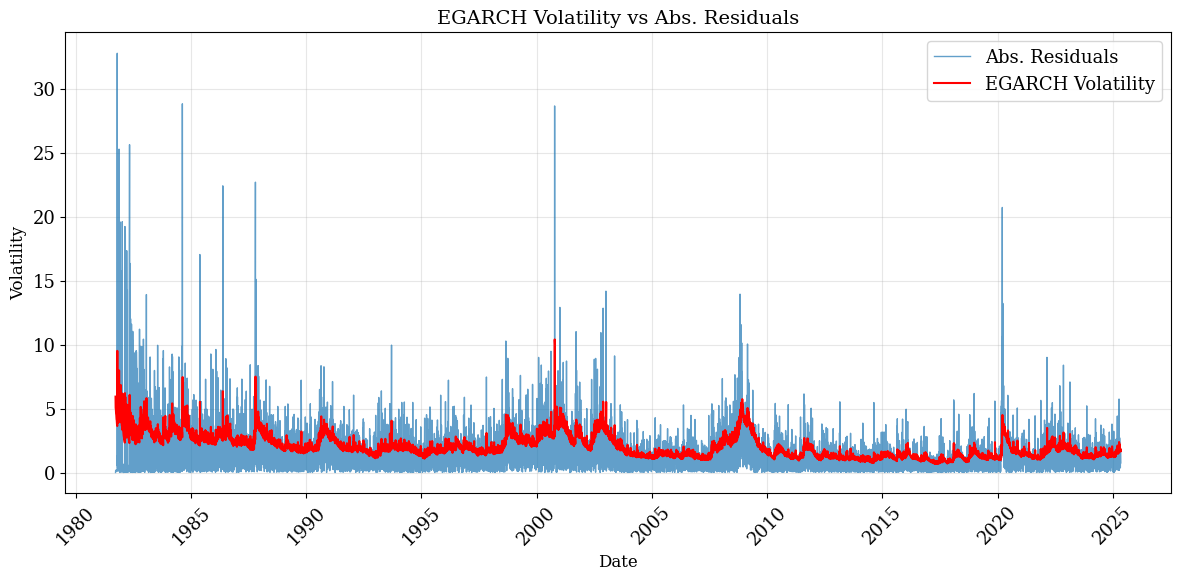

In [ ]:
plot_df = pd.DataFrame({
    'Abs. Residuals': df["abs_resid"],
    'EGARCH Volatility': predicted_egarch_volatility,
    "date":df["ds"]
    }, index=egarch_df.index)
plot_df.head()
plt.figure(figsize=(12, 6))
plt.plot(plot_df["date"], plot_df['Abs. Residuals'], linewidth=1, alpha=0.7, label='Abs. Residuals')
plt.plot(plot_df["date"], plot_df['EGARCH Volatility'], linewidth=1.5, color='red', label='EGARCH Volatility')
plt.title('EGARCH Volatility vs Abs. Residuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Format x-axis to show dates nicely if we have many observations
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The EGARCH(3,2) present a criticity with respect to the Beta as it is clearly equal to 1 and also conducting a t-test we can see how it is not statistically different from 1. This signals the presence of an integrated process within the variance (non-stationary variance exploding probably during Covid and in the early years of trading). As a result the model may appear to not be useful as it is remote that we will capture a mean reverting process. Furthermore being Beta the coefficient of the past conditional variance it looks like we have infinite memory. The gamma is grasping the leverage effect and in our case the first one is not significant, whilst the third being positive suggests positive returns increase variance more than negatives, and lastly the second gamma is negative indicating the typical leverage effect where negative ret increase variance more than positive. Concerning the plot, the volatility of EGARCH does not appear to be fully able to capture the movement in absolute residuals (proxy for realised volatility). This is consistent with the fact that the model fails to react quickly to immediate news(alfa) and tends to have more persistence in terms of past volatility(beta) (in our case beta>>alfa). Lastly even if it captures leverage effect it does not seem able to grasp extreme shocks such as covid.

Q10

In [ ]:
aparch = arch_model(df["resid"], mean='Zero', vol='APARCH', p=1, o=1, q=2, dist='normal')
aparch_result = aparch.fit(disp='on')
predicted_aparch_volatility = aparch_result.conditional_volatility
predicted_aparch_variance = predicted_aparch_volatility**2
print(aparch_result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 40899.337726276186
Iteration:      2,   Func. Count:     20,   Neg. LLF: 25665.482257450214
Iteration:      3,   Func. Count:     28,   Neg. LLF: 30482.25532073133
Iteration:      4,   Func. Count:     36,   Neg. LLF: 188432.00435862382
Iteration:      5,   Func. Count:     44,   Neg. LLF: 22507.488942345317
Iteration:      6,   Func. Count:     52,   Neg. LLF: 22450.765623661595
Iteration:      7,   Func. Count:     60,   Neg. LLF: 22633.62045665133
Iteration:      8,   Func. Count:     69,   Neg. LLF: 22490.997614076703
Iteration:      9,   Func. Count:     77,   Neg. LLF: 22417.578902863275
Iteration:     10,   Func. Count:     84,   Neg. LLF: 22417.367173762985
Iteration:     11,   Func. Count:     92,   Neg. LLF: 22416.906926690746
Iteration:     12,   Func. Count:     99,   Neg. LLF: 22416.897721898393
Iteration:     13,   Func. Count:    106,   Neg. LLF: 22416.897556245727
Iteration:     14,   Func. Count:    113,   Neg. LLF:

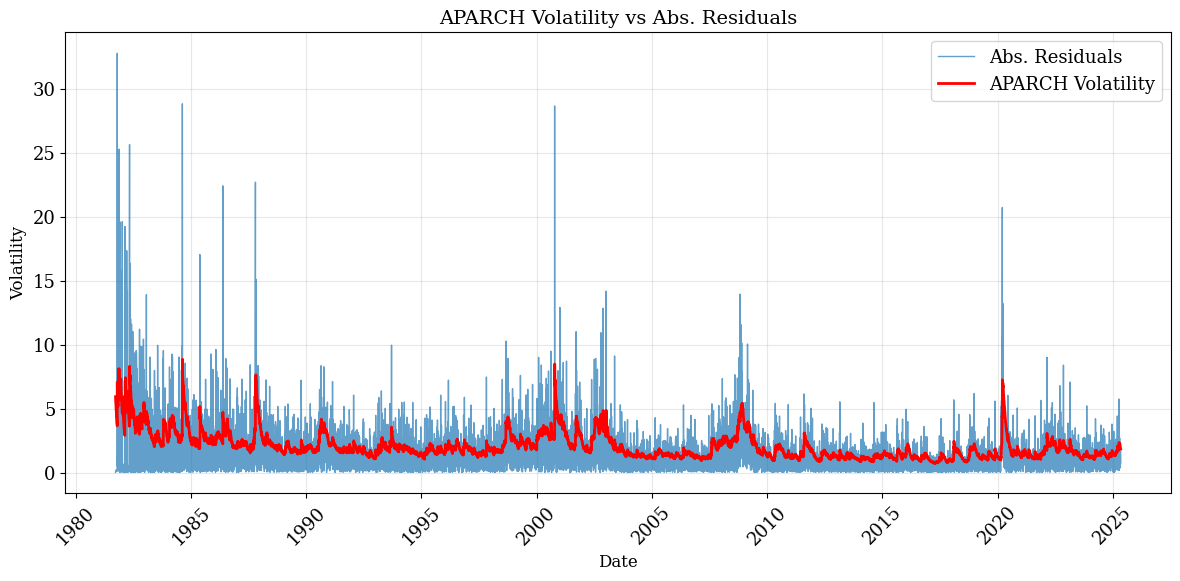

In [ ]:
plot_df = pd.DataFrame({
    'Abs. Residuals': df["abs_resid"],
    'APARCH Volatility': predicted_aparch_volatility,
    "date":df["ds"]
}, index=egarch_df.index)
plot_df.head()
plt.figure(figsize=(12, 6))
plt.plot(plot_df["date"], plot_df['Abs. Residuals'], linewidth=1, alpha=0.7, label='Abs. Residuals')
plt.plot(plot_df['date'], plot_df['APARCH Volatility'], linewidth=2, color='red', label='APARCH Volatility')

plt.title('APARCH Volatility vs Abs. Residuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Format x-axis to show dates nicely if we have many observations
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The APARCH (1,2) tries to understand from the data how they would like to be modelled, and the delta (gamma on slides) of 1.88 suggests a value very close to variance. We can safely change from the sigma^1.88 to sigma or sigma^2 thanks to the procedure adopted for the estimation, MLE, which preserves optimality. Concerning the statioanrity condition they are violated also in this case and is also confirmed by the bigger Beta coefficient comapred to alpha suggesting persistence of the past and less reactivity to news. The gamma which captures leverage is positive and confirms the fact that negative returns drive up volatility. Concenring the graph, it looks like it fails to perfectly track the absolute residuals. This is consistent with the fact that the model fails to react quickly to immediate news(alfa) and tends to have more persistence in terms of past volatility(beta) (in our case beta>>alfa). Lastly even if it captures leverage effect it does not seem able to grasp extreme shocks such as covid, as for the previous model.

Q11

In [ ]:
pred_df=df.copy()
pred_df["Predicted variance EGARCH(3,2)"]= predicted_egarch_variance
pred_df["Predicted variance APARCH(1,2)"]= predicted_aparch_variance
pred_df.dropna(inplace=True)
pred_df.head()

,ds,HDprice,ret,residsq,resid,abs_resid,"Predicted variance EGARCH(3,2)","Predicted variance APARCH(1,2)"
0,1981-09-23,0.017052,0.0,0.00000,0.000000,0.000000,35.263663,35.165629
1,1981-09-24,0.017052,0.0,0.02783,-0.166824,0.166824,29.099731,32.839398
2,1981-09-25,0.017052,0.0,0.02783,-0.166824,0.166824,25.452168,31.420005
3,1981-09-28,0.017052,0.0,0.02783,-0.166824,0.166824,24.660361,29.805841
4,1981-09-29,0.017052,0.0,0.02783,-0.166824,0.166824,23.730731,28.361052


In [ ]:
Y = pred_df['residsq']
X = pred_df['Predicted variance EGARCH(3,2)']
X = sm.add_constant(X)
modele = sm.OLS(Y, X).fit()
resultse=modele
test=dict()
test["Predicted variance EGARCH(3,2)"] = {
            'summary': resultse.summary().as_text(),
            'f_test': None,
            't_test': None
        }
try:
  f_test = resultse.f_test(f"const = 0, Predicted variance EGARCH(3,2) = 1")
  test["Predicted variance EGARCH(3,2)"]['f_test'] = f_test
except Exception as e:
  test["Predicted variance EGARCH(3,2)"]['f_test'] = f"Error performing F-test: {e}"

        # Perform and store the T-test
try:
  t_test = resultse.t_test(f"Predicted variance EGARCH(3,2) = 1")
  test["Predicted variance EGARCH(3,2)"]['t_test'] = t_test
except Exception as e:
  test["Predicted variance EGARCH(3,2)"]['t_test'] = f"Error performing T-test: {e}"

print(test["Predicted variance EGARCH(3,2)"]['summary'])
print("\nF-test for hypothesis that intercept = 0 and coefficient of regressor = 1:")
print(test["Predicted variance EGARCH(3,2)"]['f_test'])
print("\nT-test for hypothesis that the coefficient of regressor = 1:")
print(test["Predicted variance EGARCH(3,2)"]['t_test'])


                            OLS Regression Results                            
Dep. Variable:                residsq   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     423.9
Date:                Tue, 13 May 2025   Prob (F-statistic):           1.86e-92
Time:                        13:32:03   Log-Likelihood:                -50869.
No. Observations:               10994   AIC:                         1.017e+05
Df Residuals:                   10992   BIC:                         1.018e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
Y = pred_df['residsq']
X = pred_df['Predicted variance APARCH(1,2)']
X = sm.add_constant(X)
modela = sm.OLS(Y, X).fit()
resultsa=modela
test=dict()
test["Predicted variance APARCH(1,2)"] = {
            'summary': resultsa.summary().as_text(),
            'f_test': None,
            't_test': None
        }
try:
  f_test = resultsa.f_test(f"const = 0, Predicted variance APARCH(1,2) = 1")
  test["Predicted variance APARCH(1,2)"]['f_test'] = f_test
except Exception as e:
  test["Predicted variance APARCH(1,2)"]['f_test'] = f"Error performing F-test: {e}"

        # Perform and store the T-test
try:
  t_test = resultsa.t_test(f"Predicted variance APARCH(1,2) = 1")
  test["Predicted variance APARCH(1,2)"]['t_test'] = t_test
except Exception as e:
  test["Predicted variance APARCH(1,2)"]['t_test'] = f"Error performing T-test: {e}"

print(test["Predicted variance APARCH(1,2)"]['summary'])
print("\nF-test for hypothesis that intercept = 0 and coefficient of regressor = 1:")
print(test["Predicted variance APARCH(1,2)"]['f_test'])
print("\nT-test for hypothesis that the coefficient of regressor = 1:")
print(test["Predicted variance APARCH(1,2)"]['t_test'])

                            OLS Regression Results                            
Dep. Variable:                residsq   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     472.3
Date:                Tue, 13 May 2025   Prob (F-statistic):          1.43e-102
Time:                        13:32:03   Log-Likelihood:                -50846.
No. Observations:               10994   AIC:                         1.017e+05
Df Residuals:                   10992   BIC:                         1.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
cond_var_model = results_egarch

While both models seem to perform similarly from a visual standpoint, looking at the IC, both AIC and BIC are lower for the APARCH(1,2). Moreover, the log likelihood of the latter is higher. This implies APARCH seems to do a better job at tracking squared residuals. However, after performing the auxiliary regressions, we can see how the APARCH is clearly not specified correctly, as both a and b coefficients are respectively statistically different from 0 and 1. The EGARCH(3,2) on the other hand, passes the F-test, and we can see how the a and b coefficients are not statistically different from 0 and 1, indicating the model is robust. Considering all the above, despite the higher IC, we chose the EGARCH as our model as the APARCH performed too poorly in the auxiliary regression.

Q12

In [ ]:
advanced_df = df.copy()
advanced_df["predicted_egarch_variance"]=predicted_egarch_variance
advanced_df = advanced_df[advanced_df['ds'] <= '2024-12-31']
advanced_df

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance
0,1981-09-23,0.017052,0.000000,0.000000,0.000000,0.000000,35.263663
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824,0.166824,29.099731
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824,0.166824,25.452168
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824,0.166824,24.660361
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824,0.166824,23.730731
...,...,...,...,...,...,...,...
10904,2024-12-24,393.641937,0.940252,0.418282,0.646747,0.646747,1.849651
10905,2024-12-26,392.648254,-0.252433,0.206997,-0.454969,0.454969,1.932254
10906,2024-12-27,390.382599,-0.577019,0.748799,-0.865332,0.865332,1.797867
10907,2024-12-30,386.974213,-0.873089,0.830451,-0.911291,0.911291,2.041694


In [ ]:
T_df = len(advanced_df)
holdout_size_df = int(0.2 * T_df)
train_val_df = advanced_df.iloc[:-holdout_size_df].copy()   # first 80%
holdout_df   = advanced_df.iloc[-holdout_size_df:].copy()   # last 20%

In [ ]:
train_val_df

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance
0,1981-09-23,0.017052,0.000000,0.000000,0.000000,0.000000,35.263663
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824,0.166824,29.099731
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824,0.166824,25.452168
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824,0.166824,24.660361
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824,0.166824,23.730731
...,...,...,...,...,...,...,...
8723,2016-04-26,109.224289,-0.228524,0.121875,-0.349106,0.349106,1.112287
8724,2016-04-27,109.555153,0.302922,0.026184,0.161813,0.161813,1.151703
8725,2016-04-28,107.117943,-2.224642,5.740240,-2.395880,2.395880,1.129000
8726,2016-04-29,108.054108,0.873957,0.617671,0.785921,0.785921,1.812842


In [ ]:
holdout_df

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance
8728,2016-05-03,108.578690,-1.109875,1.793874,-1.339356,1.339356,1.365685
8729,2016-05-04,109.079018,0.460798,0.156458,0.395548,0.395548,1.515786
8730,2016-05-05,108.683586,-0.362518,0.295970,-0.544032,0.544032,1.550632
8731,2016-05-06,109.514832,0.764831,0.346898,0.588980,0.588980,1.233839
8732,2016-05-09,109.950638,0.397943,0.159355,0.399193,0.399193,1.329175
...,...,...,...,...,...,...,...
10904,2024-12-24,393.641937,0.940252,0.418282,0.646747,0.646747,1.849651
10905,2024-12-26,392.648254,-0.252433,0.206997,-0.454969,0.454969,1.932254
10906,2024-12-27,390.382599,-0.577019,0.748799,-0.865332,0.865332,1.797867
10907,2024-12-30,386.974213,-0.873089,0.830451,-0.911291,0.911291,2.041694


Firstly, it must be said that since the data on MktTbill_daily excel was available up to 12/31/2024, for the sake of comparability of our forecasts with the ones we will perform using the ML model, we cut the dataset at this last available date. After that, we split the remaining values into a training set of 80% of the data and a holdout/test sample containing 20% of the data. The conditional mean model was specified on the entire dataset meaning it fully knows the series on which it will perform the forecasts. Therefore, the extracted parameters will be based on information which is also derived from our testing sample. It becomes clear that the conditional mean model will have an unfair advantage as it peeked into the future.

Q13

In [ ]:
#train_resid = train_val_df['resid'].iloc[:holdout_size_df]
holdout_resid = holdout_df['resid']
train_resid=train_val_df['resid']
holdout_resid = holdout_resid.reset_index(drop=True)

In [ ]:
train_resid

,resid
0,0.000000
1,-0.166824
2,-0.166824
3,-0.166824
4,-0.166824
...,...
8723,-0.349106
8724,0.161813
8725,-2.395880
8726,0.785921


In [ ]:
holdout_resid

,resid
0,-1.339356
1,0.395548
2,-0.544032
3,0.588980
4,0.399193
...,...
2176,0.646747
2177,-0.454969
2178,-0.865332
2179,-0.911291


In [ ]:
phi_0 = cond_mean_model.params[0]  # Assuming 'intercept' is the first parameter
phi_1 = cond_mean_model.params[1]  # Assuming 'ar.L1' is the second parameter
phi_2 = cond_mean_model.params[2]  # Assuming 'ar.L2' is the third parameter
phi_3 = cond_mean_model.params[3]  # Assuming 'ar.L3' is the fourth parameter
phi_4 = cond_mean_model.params[4]  # Assuming 'ar.L4' is the fifth parameter
phi_5 = cond_mean_model.params[5]  # Assuming 'ar.L5' is the sixth parameter
phi_6 = cond_mean_model.params[6]  # Assuming 'ar.L6' is the seventh parameter
theta_1 = cond_mean_model.params[7]  # Assuming 'ma.L1' is the eigth parameter
theta_2 = cond_mean_model.params[8]  # Assuming 'ma.L2' is the ninth parameter
theta_3 = cond_mean_model.params[9]  # Assuming 'ma.L3' is the tenth parameter
theta_4 = cond_mean_model.params[10] # Assuming 'ma.L4' is the eleventh parameter
theta_5 = cond_mean_model.params[11] # Assuming 'ma.L5' is the twelfth parameter
theta_6 = cond_mean_model.params[12] # Assuming 'ma.L6' is the thirteenth parameter
#sigma2 = cond_mean_model.params["sigma2"] # Assuming sigma2 is still accessible by name

In [ ]:
#train_y = train_val_df['ret'].iloc[:holdout_size_df]
#holdout_y = holdout_df['ret'].iloc[-holdout_size_df:]
train_y = train_val_df['ret']
holdout_y = holdout_df['ret']
holdout_y = holdout_y.reset_index(drop=True)

In [ ]:
oos_forecast_arma = np.zeros(holdout_size_df) #sigma squared
epsilon_oos = np.zeros(holdout_size_df)

oos_forecast_arma[0]=(phi_0+
                      phi_1 * train_y.iloc[-1]+
                      phi_2 * train_y.iloc[-2]+
                      phi_3 * train_y.iloc[-3]+
                      phi_4 * train_y.iloc[-4]+
                      phi_5 * train_y.iloc[-5]+
                      phi_6 * train_y.iloc[-6]+
                      theta_1 * train_resid.iloc[-1]+
                      theta_2 * train_resid.iloc[-2]+
                      theta_3 * train_resid.iloc[-3]+
                      theta_4 * train_resid.iloc[-4]+
                      theta_5 * train_resid.iloc[-5]+
                      theta_6 * train_resid.iloc[-6]
                      )
epsilon_oos[0] = holdout_y.iloc[0] - oos_forecast_arma[0]

oos_forecast_arma[1]=(phi_0+
                      phi_1 * holdout_y[0]+
                      phi_2 * train_y.iloc[-1]+
                      phi_3 * train_y.iloc[-2]+
                      phi_4 * train_y.iloc[-3]+
                      phi_5 * train_y.iloc[-4]+
                      phi_6 * train_y.iloc[-5]+
                      theta_1 * epsilon_oos[0]+
                      theta_2 * train_resid.iloc[-1]+
                      theta_3 * train_resid.iloc[-2]+
                      theta_4 * train_resid.iloc[-3]+
                      theta_5 * train_resid.iloc[-4]+
                      theta_6 * train_resid.iloc[-5]
                      )
epsilon_oos[1] = holdout_y.iloc[1] - oos_forecast_arma[1]

oos_forecast_arma[2]=(phi_0+
                      phi_1 * holdout_y[1]+
                      phi_2 * holdout_y[0]+
                      phi_3 * train_y.iloc[-1]+
                      phi_4 * train_y.iloc[-2]+
                      phi_5 * train_y.iloc[-3]+
                      phi_6 * train_y.iloc[-4]+
                      theta_1 * epsilon_oos[1]+
                      theta_2 * epsilon_oos[0]+
                      theta_3 * train_resid.iloc[-1]+
                      theta_4 * train_resid.iloc[-2]+
                      theta_5 * train_resid.iloc[-3]+
                      theta_6 * train_resid.iloc[-4]
                      )
epsilon_oos[2] = holdout_y.iloc[2] - oos_forecast_arma[2]

oos_forecast_arma[3]=(phi_0+
                      phi_1 * holdout_y[2]+
                      phi_2 * holdout_y[1]+
                      phi_3 * holdout_y[0]+
                      phi_4 * train_y.iloc[-1]+
                      phi_5 * train_y.iloc[-2]+
                      phi_6 * train_y.iloc[-3]+
                      theta_1 * epsilon_oos[2]+
                      theta_2 * epsilon_oos[1]+
                      theta_3 * epsilon_oos[0]+
                      theta_4 * train_resid.iloc[-1]+
                      theta_5 * train_resid.iloc[-2]+
                      theta_6 * train_resid.iloc[-3]
                      )
epsilon_oos[3] = holdout_y.iloc[3] - oos_forecast_arma[3]

oos_forecast_arma[4]=(phi_0+
                      phi_1 * holdout_y[3]+
                      phi_2 * holdout_y[2]+
                      phi_3 * holdout_y[1]+
                      phi_4 * holdout_y[0]+
                      phi_5 * train_y.iloc[-1]+
                      phi_6 * train_y.iloc[-2]+
                      theta_1 * epsilon_oos[3]+
                      theta_2 * epsilon_oos[2]+
                      theta_3 * epsilon_oos[1]+
                      theta_4 * epsilon_oos[0]+
                      theta_5 * train_resid.iloc[-1]+
                      theta_6 * train_resid.iloc[-2]
                      )
epsilon_oos[4] = holdout_y.iloc[4] - oos_forecast_arma[4]

oos_forecast_arma[5]=(phi_0+
                      phi_1 * holdout_y[4]+
                      phi_2 * holdout_y[3]+
                      phi_3 * holdout_y[2]+
                      phi_4 * holdout_y[1]+
                      phi_5 * holdout_y[0]+
                      phi_6 * train_y.iloc[-1]+
                      theta_1 * epsilon_oos[4]+
                      theta_2 * epsilon_oos[3]+
                      theta_3 * epsilon_oos[2]+
                      theta_4 * epsilon_oos[1]+
                      theta_5 * epsilon_oos[0]+
                      theta_6 * train_resid.iloc[-1]
                      )
epsilon_oos[5] = holdout_y.iloc[5] - oos_forecast_arma[5]


In [ ]:
for t in range(6, holdout_size_df):
  oos_forecast_arma[t]=(phi_0+
                      phi_1 * holdout_y[t-1]+
                      phi_2 * holdout_y[t-2]+
                      phi_3 * holdout_y[t-3]+
                      phi_4 * holdout_y[t-4]+
                      phi_5 * holdout_y[t-5]+
                      phi_6 * holdout_y[t-6]+
                      theta_1 * epsilon_oos[t-1]+
                      theta_2 * epsilon_oos[t-2]+
                      theta_3 * epsilon_oos[t-3]+
                      theta_4 * epsilon_oos[t-4]+
                      theta_5 * epsilon_oos[t-5]+
                      theta_6 * epsilon_oos[t-6]
                      )
epsilon_oos[t] = holdout_y.iloc[t] - oos_forecast_arma[t]

In [ ]:
fig_returns = go.Figure()
fig_returns.add_trace(go.Scatter(
    x=holdout_df['ds'], y=oos_forecast_arma,
    mode='lines',
    name='OOS forecast',
    line=dict(color='firebrick', width=2.0)))

fig_returns.add_trace(go.Scatter(
    x=holdout_df['ds'], y=holdout_y,
    mode='lines',
    name='realised returns',
    line=dict(color='steelblue', width=1.5),
    opacity=0.5))
fig_returns.update_layout(
    title=dict(
        text=f'ARMA(6,6) conditional Mean',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False
    ),
    yaxis=dict(
        title='returns %',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False,
        zeroline=False
    ),
    font=dict(
        family="Serif",
        size=25,
        color="black"
    ),
)

fig_returns.show()

In [ ]:
train_std_resid = (train_resid - train_resid.mean()) / train_resid.std()
pred_egarch_var = train_val_df['predicted_egarch_variance']
ev_abs_z = np.sqrt(2 / np.pi)

In [ ]:
pred_egarch_var

,predicted_egarch_variance
0,35.263663
1,29.099731
2,25.452168
3,24.660361
4,23.730731
...,...
8723,1.112287
8724,1.151703
8725,1.129000
8726,1.812842


In [ ]:
oos_forecasts_egarch = np.zeros(holdout_size_df) #sigma squared
std_residuals_oos = np.zeros(holdout_size_df)

In [ ]:
oos_forecasts_egarch

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
omega_egarch = cond_var_model.params['omega']
alpha1_egarch = cond_var_model.params['alpha[1]']
alpha2_egarch = cond_var_model.params['alpha[2]']
alpha3_egarch = cond_var_model.params['alpha[3]']
gamma1_egarch = cond_var_model.params['gamma[1]']
gamma2_egarch = cond_var_model.params['gamma[2]']
gamma3_egarch = cond_var_model.params['gamma[3]']
beta1_egarch = cond_var_model.params['beta[1]']
beta2_egarch = cond_var_model.params['beta[2]']

In [ ]:
train_std_resid

,resid
0,-0.006347
1,-0.075066
2,-0.075066
3,-0.075066
4,-0.075066
...,...
8723,-0.150153
8724,0.060308
8725,-0.993272
8726,0.317395


In [ ]:
oos_forecasts_egarch[0] =(
    omega_egarch
    + alpha1_egarch * (abs(train_std_resid.iloc[-1]) - ev_abs_z)
    + alpha2_egarch * (abs(train_std_resid.iloc[-2]) - ev_abs_z)
    + alpha3_egarch * (abs(train_std_resid.iloc[-3]) - ev_abs_z)
    + gamma1_egarch * train_std_resid.iloc[-1]
    + gamma2_egarch * train_std_resid.iloc[-2]
    + gamma3_egarch * train_std_resid.iloc[-3]
    + beta1_egarch * np.log(pred_egarch_var.iloc[-1])
    + beta2_egarch * np.log(pred_egarch_var.iloc[-2])
)

std_residuals_oos[0] = holdout_resid.iloc[0] / np.sqrt(np.exp(oos_forecasts_egarch[0]))

oos_forecasts_egarch[1] =(
    omega_egarch
    + alpha1_egarch * (abs(std_residuals_oos[0]) - ev_abs_z)
    + alpha2_egarch * (abs(train_std_resid.iloc[-1]) - ev_abs_z)
    + alpha3_egarch * (abs(train_std_resid.iloc[-2]) - ev_abs_z)
    + gamma1_egarch * std_residuals_oos[0]
    + gamma2_egarch * train_std_resid.iloc[-1]
    + gamma3_egarch * train_std_resid.iloc[-2]
    + beta1_egarch * oos_forecasts_egarch[0]
    + beta2_egarch * np.log(pred_egarch_var.iloc[-1])
)

std_residuals_oos[1] = holdout_resid.iloc[1] / np.sqrt(np.exp(oos_forecasts_egarch[1]))

oos_forecasts_egarch[2] =(
    omega_egarch
    + alpha1_egarch * (abs(std_residuals_oos[1]) - ev_abs_z)
    + alpha2_egarch * (abs(std_residuals_oos[0]) - ev_abs_z)
    + alpha3_egarch * (abs(train_std_resid.iloc[-1]) - ev_abs_z)
    + gamma1_egarch * std_residuals_oos[1]
    + gamma2_egarch * std_residuals_oos[0]
    + gamma3_egarch * train_std_resid.iloc[-1]
    + beta1_egarch * oos_forecasts_egarch[1]
    + beta2_egarch * oos_forecasts_egarch[2]
)

std_residuals_oos[2] = holdout_resid.iloc[2] / np.sqrt(np.exp(oos_forecasts_egarch[2]))

In [ ]:
for t in range(3, holdout_size_df):
  oos_forecasts_egarch[t] =(
    omega_egarch
    + alpha1_egarch * (abs(std_residuals_oos[t-1]) - ev_abs_z)
    + alpha2_egarch * (abs(std_residuals_oos[t-2]) - ev_abs_z)
    + alpha3_egarch * (abs(std_residuals_oos[t-3]) - ev_abs_z)
    + gamma1_egarch * std_residuals_oos[t-1]
    + gamma2_egarch * std_residuals_oos[t-2]
    + gamma3_egarch * std_residuals_oos[t-3]
    + beta1_egarch * oos_forecasts_egarch[t-1]
    + beta2_egarch * oos_forecasts_egarch[t-2]
  )

  std_residuals_oos[t] = holdout_resid.iloc[t] / np.sqrt(np.exp(oos_forecasts_egarch[t]))

In [ ]:
oos_forecasts_egarch_var=np.exp(oos_forecasts_egarch)
oos_forecasts_egarch_var[1000]

np.float64(11.172707477391192)

In [ ]:
fig_returns = go.Figure()
fig_returns.add_trace(go.Scatter(
    x=holdout_df['ds'], y= oos_forecasts_egarch_var,
    mode='lines',
    name='OOS forecast',
    line=dict(color='firebrick', width=2.0)))

fig_returns.add_trace(go.Scatter(
    x=holdout_df['ds'], y= holdout_resid**2,
    mode='lines',
    name='Squared Residual',
    line=dict(color='steelblue', width=1.5),
    opacity=0.5))
fig_returns.update_layout(
    title=dict(
        text=f'EGARCH(3,2) OOS Conditional Variance',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False
    ),
    yaxis=dict(
        title='Squared Residual / Variance',
        titlefont=dict(size=25),
        tickfont=dict(size=25),
        showgrid=False,
        zeroline=False
    ),
    font=dict(
        family="Serif",
        size=25,
        color="black"
    ),
)

fig_returns.show()

In [ ]:
forecast_error_egarch = holdout_resid**2 - oos_forecasts_egarch_var
forecast_error_arma = holdout_y - oos_forecast_arma
MSFE_egarch = np.mean(np.array(forecast_error_egarch)**2)
MSFE_arma = np.mean(np.array(forecast_error_arma)**2)
print(MSFE_egarch)
print(MSFE_arma)

125.15111442889982
3.6720917400885873


The ARMA(6,6) seems to track the returns fairly well, and has a relatively low MSFE of 3.67. This results were expected as the model was estimated on the entire dataset. Therefore its parameters are based on information found also in the test set, which is the one on which we perform the forecast. On the other hand, quite surprisingly, the MSFE for the EGARCH(3,2) forecasts is very high, 125.14. Also from the plot, it seems like it does't perform a great job. It is surprising because as for the ARMA, the model was estimated on the entire dataset, therefore we were expecting a fairly good forecast of squared residuals (bearing in mind squared residuals are a poor proxy for variance). A possible reason for this, lies in the fact that the variance is non-stationary (explosive) as noted in point 9. For what regards the visual comparison with the plot in point 9, it must be noted that this is not too relevant as here we are looking at forecasted variance and squared residuals, while in point 9 we had absolute residuals and conditional volatility. As we expected, the latter looks way better. Plotting volatility forecasts vs absolute oos residuals would surely yield a better visual result.

Q14

In [ ]:
df_tbill=pd.read_excel("/content/MktTbill_daily.xlsx")
df_tbill.rename(columns={'Unnamed: 0': 'ds'}, inplace=True)
df_tbill['ds'] = pd.to_datetime(df_tbill['ds'].astype(str), format='%Y%m%d')
df_tbill = df_tbill.sort_values('ds').reset_index(drop=True)
df_tbill

,ds,Mkt-RF,RF
0,1926-07-01,0.10,0.009
1,1926-07-02,0.45,0.009
2,1926-07-06,0.17,0.009
3,1926-07-07,0.09,0.009
4,1926-07-08,0.21,0.009
...,...,...,...
25896,2024-12-24,1.11,0.017
25897,2024-12-26,0.02,0.017
25898,2024-12-27,-1.17,0.017
25899,2024-12-30,-1.09,0.017


In [ ]:
uniform_date_beg = '1981-09-23'#beginning of train val

In [ ]:
df_tbill = df_tbill[(df_tbill['ds'] >= uniform_date_beg)]

In [ ]:
df_tbill.reset_index(drop=True, inplace=True)

In [ ]:
df_tbill

,ds,Mkt-RF,RF
0,1981-09-23,-1.22,0.059
1,1981-09-24,-0.40,0.059
2,1981-09-25,-2.40,0.059
3,1981-09-28,1.93,0.059
4,1981-09-29,0.85,0.059
...,...,...,...
10904,2024-12-24,1.11,0.017
10905,2024-12-26,0.02,0.017
10906,2024-12-27,-1.17,0.017
10907,2024-12-30,-1.09,0.017


In [ ]:
'''uniform_date_beg = '1981-09-23'#beginning of train val
uniform_date_end = '2016-08-08'#last day training datset
df_tbill = df_tbill[(df_tbill['ds'] >= uniform_date_beg) & (df_tbill['ds'] <= uniform_date_end)]
df_tbill'''

In [ ]:
advanced_df=advanced_df.copy()

In [ ]:
advanced_df_ML=advanced_df.merge(df_tbill, left_on='ds', right_on='ds', how='left')

In [ ]:
advanced_df_ML

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance,Mkt-RF,RF
0,1981-09-23,0.017052,0.000000,0.000000,0.000000,0.000000,35.263663,-1.22,0.059
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824,0.166824,29.099731,-0.40,0.059
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824,0.166824,25.452168,-2.40,0.059
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824,0.166824,24.660361,1.93,0.059
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824,0.166824,23.730731,0.85,0.059
...,...,...,...,...,...,...,...,...,...
10904,2024-12-24,393.641937,0.940252,0.418282,0.646747,0.646747,1.849651,1.11,0.017
10905,2024-12-26,392.648254,-0.252433,0.206997,-0.454969,0.454969,1.932254,0.02,0.017
10906,2024-12-27,390.382599,-0.577019,0.748799,-0.865332,0.865332,1.797867,-1.17,0.017
10907,2024-12-30,386.974213,-0.873089,0.830451,-0.911291,0.911291,2.041694,-1.09,0.017


In [ ]:
advanced_df_ML['dayofweek']  = advanced_df_ML['ds'].dt.dayofweek # Monday=0, Sunday=6
advanced_df_ML['dayofmonth'] = advanced_df_ML['ds'].dt.day

In [ ]:
dow_dummies = pd.get_dummies(advanced_df_ML['dayofweek'], prefix='dow', dtype=int)
advanced_df_ML = pd.concat([advanced_df_ML, dow_dummies.sort_index(axis=1)], axis=1)

In [ ]:
def binary_encoding(vars_to_encode = 10):
    # Calculate Min number of binary vars needed to encode vars_to_encode
    repeat = int(np.ceil(np.log2(vars_to_encode)))

    # create name of cols
    name_col=[]
    for i in range(1, repeat+1):
        nc = 'binary_' + str(i)
        name_col.append(nc)

    perm=[]
    for p in itertools.product([0, 1], repeat=repeat):
         perm.append(p)

    perm = pd.DataFrame(perm[(2**repeat - vars_to_encode):], columns=name_col)

    return perm

In [ ]:
dom_levels = sorted(advanced_df_ML['dayofmonth'].unique())   # [1,2,…,31]
dom_enc = binary_encoding(len(dom_levels))
dom_enc.index = dom_levels
dom_enc.columns = [f'dom_{i}' for i in range(dom_enc.shape[1])]
advanced_df_ML = (
    advanced_df_ML
    .merge(dom_enc, left_on='dayofmonth',  right_index=True, how='left')
)

In [ ]:
advanced_df_ML = advanced_df_ML.drop(columns=['dayofweek','dayofmonth'])

In [ ]:
advanced_df_ML

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance,Mkt-RF,RF,dow_0,dow_1,dow_2,dow_3,dow_4,dom_0,dom_1,dom_2,dom_3,dom_4
0,1981-09-23,0.017052,0.000000,0.000000,0.000000,0.000000,35.263663,-1.22,0.059,0,0,1,0,0,1,0,1,1,1
1,1981-09-24,0.017052,0.000000,0.027830,-0.166824,0.166824,29.099731,-0.40,0.059,0,0,0,1,0,1,1,0,0,0
2,1981-09-25,0.017052,0.000000,0.027830,-0.166824,0.166824,25.452168,-2.40,0.059,0,0,0,0,1,1,1,0,0,1
3,1981-09-28,0.017052,0.000000,0.027830,-0.166824,0.166824,24.660361,1.93,0.059,1,0,0,0,0,1,1,1,0,0
4,1981-09-29,0.017052,0.000000,0.027830,-0.166824,0.166824,23.730731,0.85,0.059,0,1,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,2024-12-24,393.641937,0.940252,0.418282,0.646747,0.646747,1.849651,1.11,0.017,0,1,0,0,0,1,1,0,0,0
10905,2024-12-26,392.648254,-0.252433,0.206997,-0.454969,0.454969,1.932254,0.02,0.017,0,0,0,1,0,1,1,0,1,0
10906,2024-12-27,390.382599,-0.577019,0.748799,-0.865332,0.865332,1.797867,-1.17,0.017,0,0,0,0,1,1,1,0,1,1
10907,2024-12-30,386.974213,-0.873089,0.830451,-0.911291,0.911291,2.041694,-1.09,0.017,1,0,0,0,0,1,1,1,1,0


In [ ]:
# 1×3 grid for two overlayed histograms
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=['HDret', 'Excess Mkt Ret','Risk free Rate']
)

# HDret
fig.add_trace(
    go.Histogram(
        x=advanced_df_ML['ret'],
        name='ret',
        opacity=0.6,
        nbinsx=50
    ),
    row=1, col=1
)
# excess
fig.add_trace(
    go.Histogram(
        x=advanced_df_ML['Mkt-RF'],
        name='Mkt-RF',
        opacity=0.6,
        nbinsx=50
    ),
    row=1, col=2
)

# RF
fig.add_trace(
    go.Histogram(
        x=advanced_df_ML['RF'],
        name='RF',
        opacity=0.6,
        nbinsx=50
    ),
    row=1, col=3
)

# Layout styling
fig.update_layout(
    barmode='overlay',
    title_text='Distributions',
    title_x=0.5,
    font=dict(
        family="Serif",
        size=20,
        color="black"
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-1,
        xanchor='center',
        x=0.5
    ),
    margin=dict(t=80, b=80, l=60, r=60)
)

# Axis labels
fig.update_xaxes(title_text='Ret', row=1, col=1)
fig.update_xaxes(title_text='Ret', row=1, col=2)
fig.update_xaxes(title_text='Ret', row=1, col=3)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.show()


In [ ]:
lags=[2,3,5,6,9,11,18]
for lag in lags:
    advanced_df_ML[f'lag_ret_{lag}'] = advanced_df_ML['ret'].shift(lag)
    advanced_df_ML[f'lag_Mkt-RF_{lag}'] = advanced_df_ML['Mkt-RF'].shift(lag)
    advanced_df_ML[f'lag_RF_{lag}'] = advanced_df_ML['RF'].shift(lag)

In [ ]:
advanced_df_ML.dropna(inplace=True)
advanced_df_ML.reset_index(drop=True, inplace=True)

In [ ]:
advanced_df_ML

,ds,HDprice,ret,residsq,resid,abs_resid,predicted_egarch_variance,Mkt-RF,RF,dow_0,...,lag_RF_6,lag_ret_9,lag_Mkt-RF_9,lag_RF_9,lag_ret_11,lag_Mkt-RF_11,lag_RF_11,lag_ret_18,lag_Mkt-RF_18,lag_RF_18
0,1981-10-19,0.017052,0.000000,0.017249,-0.131335,0.131335,13.772688,-0.21,0.054,1,...,0.054,0.000000,-0.14,0.054,0.000000,1.97,0.054,0.000000,-1.22,0.059
1,1981-10-20,0.022668,32.928733,1076.457286,32.809408,32.809408,13.245484,0.95,0.054,0,...,0.054,0.000000,1.55,0.054,0.000000,0.31,0.054,0.000000,-0.40,0.059
2,1981-10-21,0.022668,0.000000,0.276464,-0.525798,0.525798,90.639990,-0.12,0.054,0,...,0.054,0.000000,0.88,0.054,0.000000,-0.14,0.054,0.000000,-2.40,0.059
3,1981-10-22,0.022668,0.000000,1.703543,1.305199,1.305199,23.959100,-0.37,0.054,0,...,0.054,0.000000,-0.51,0.054,0.000000,1.55,0.054,0.000000,1.93,0.059
4,1981-10-23,0.022668,0.000000,1.677126,1.295039,1.295039,19.123943,-0.80,0.054,0,...,0.054,0.000000,-0.21,0.054,0.000000,0.88,0.054,0.000000,0.85,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10886,2024-12-24,393.641937,0.940252,0.418282,0.646747,0.646747,1.849651,1.11,0.017,0,...,0.017,-0.286328,0.87,0.017,-0.507682,-0.74,0.017,-0.018717,-0.39,0.020
10887,2024-12-26,392.648254,-0.252433,0.206997,-0.454969,0.454969,1.932254,0.02,0.017,0,...,0.017,-1.651708,-0.63,0.017,-1.535491,-0.37,0.017,0.454130,0.54,0.020
10888,2024-12-27,390.382599,-0.577019,0.748799,-0.865332,0.865332,1.797867,-1.17,0.017,0,...,0.017,0.617730,-0.05,0.017,-0.286328,0.87,0.017,-0.505680,0.22,0.017
10889,2024-12-30,386.974213,-0.873089,0.830451,-0.911291,0.911291,2.041694,-1.09,0.017,1,...,0.017,-1.503678,0.47,0.017,-1.651708,-0.63,0.017,0.559781,0.03,0.017


In [ ]:
df_ret=advanced_df_ML[['ds','ret']]

In [ ]:
advanced_df_ML.columns

Index(['ds', 'HDprice', 'ret', 'residsq', 'resid', 'abs_resid',
       'predicted_egarch_variance', 'Mkt-RF', 'RF', 'dow_0', 'dow_1', 'dow_2',
       'dow_3', 'dow_4', 'dom_0', 'dom_1', 'dom_2', 'dom_3', 'dom_4',
       'lag_ret_2', 'lag_Mkt-RF_2', 'lag_RF_2', 'lag_ret_3', 'lag_Mkt-RF_3',
       'lag_RF_3', 'lag_ret_5', 'lag_Mkt-RF_5', 'lag_RF_5', 'lag_ret_6',
       'lag_Mkt-RF_6', 'lag_RF_6', 'lag_ret_9', 'lag_Mkt-RF_9', 'lag_RF_9',
       'lag_ret_11', 'lag_Mkt-RF_11', 'lag_RF_11', 'lag_ret_18',
       'lag_Mkt-RF_18', 'lag_RF_18'],
      dtype='object')

In [ ]:
advanced_df_ML.drop(columns=['HDprice','residsq','resid','abs_resid','Mkt-RF','RF'], inplace=True)

In [ ]:
advanced_df_ML

,ds,ret,predicted_egarch_variance,dow_0,dow_1,dow_2,dow_3,dow_4,dom_0,dom_1,...,lag_RF_6,lag_ret_9,lag_Mkt-RF_9,lag_RF_9,lag_ret_11,lag_Mkt-RF_11,lag_RF_11,lag_ret_18,lag_Mkt-RF_18,lag_RF_18
0,1981-10-19,0.000000,13.772688,1,0,0,0,0,1,0,...,0.054,0.000000,-0.14,0.054,0.000000,1.97,0.054,0.000000,-1.22,0.059
1,1981-10-20,32.928733,13.245484,0,1,0,0,0,1,0,...,0.054,0.000000,1.55,0.054,0.000000,0.31,0.054,0.000000,-0.40,0.059
2,1981-10-21,0.000000,90.639990,0,0,1,0,0,1,0,...,0.054,0.000000,0.88,0.054,0.000000,-0.14,0.054,0.000000,-2.40,0.059
3,1981-10-22,0.000000,23.959100,0,0,0,1,0,1,0,...,0.054,0.000000,-0.51,0.054,0.000000,1.55,0.054,0.000000,1.93,0.059
4,1981-10-23,0.000000,19.123943,0,0,0,0,1,1,0,...,0.054,0.000000,-0.21,0.054,0.000000,0.88,0.054,0.000000,0.85,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10886,2024-12-24,0.940252,1.849651,0,1,0,0,0,1,1,...,0.017,-0.286328,0.87,0.017,-0.507682,-0.74,0.017,-0.018717,-0.39,0.020
10887,2024-12-26,-0.252433,1.932254,0,0,0,1,0,1,1,...,0.017,-1.651708,-0.63,0.017,-1.535491,-0.37,0.017,0.454130,0.54,0.020
10888,2024-12-27,-0.577019,1.797867,0,0,0,0,1,1,1,...,0.017,0.617730,-0.05,0.017,-0.286328,0.87,0.017,-0.505680,0.22,0.017
10889,2024-12-30,-0.873089,2.041694,1,0,0,0,0,1,1,...,0.017,-1.503678,0.47,0.017,-1.651708,-0.63,0.017,0.559781,0.03,0.017


In [ ]:
df_ret=advanced_df_ML[['ds','ret']]

In [ ]:
#separate target vs feature
drop_col=['ds','ret']
X=[col for col in advanced_df_ML.columns if col not in drop_col]
X=advanced_df_ML[X]
y=advanced_df_ML['ret']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10891 entries, 0 to 10890
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   predicted_egarch_variance  10891 non-null  float64
 1   dow_0                      10891 non-null  int64  
 2   dow_1                      10891 non-null  int64  
 3   dow_2                      10891 non-null  int64  
 4   dow_3                      10891 non-null  int64  
 5   dow_4                      10891 non-null  int64  
 6   dom_0                      10891 non-null  int64  
 7   dom_1                      10891 non-null  int64  
 8   dom_2                      10891 non-null  int64  
 9   dom_3                      10891 non-null  int64  
 10  dom_4                      10891 non-null  int64  
 11  lag_ret_2                  10891 non-null  float64
 12  lag_Mkt-RF_2               10891 non-null  float64
 13  lag_RF_2                   10891 non-null  flo

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
#global scaling
feature_cols = X_train_val.columns.tolist()
categorical_cols = ['dow_0','dow_1','dow_2','dow_3','dow_4','dom_0','dom_1','dom_2','dom_3','dom_4']
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

In [ ]:
train_val_means = X_train_val[numeric_cols].mean()
train_val_stds  = X_train_val[numeric_cols].std(ddof=0)
X_train_val_scaled = X_train_val.copy()
X_test_scaled = X_test.copy()

In [ ]:
X_train_val_scaled[numeric_cols] = (X_train_val[numeric_cols] - train_val_means) / train_val_stds
X_test_scaled[numeric_cols] = (X_test[numeric_cols] - train_val_means) / train_val_stds

In [ ]:
y_train_val_mean = y_train_val.mean()
y_train_val_std  = y_train_val.std(ddof=0)

In [ ]:
y_train_val_scaled = y_train_val.copy()
y_test_scaled = y_test.copy()

In [ ]:
y_train_val_scaled = (y_train_val - y_train_val_mean) / y_train_val_std
y_test_scaled = (y_test - y_train_val_mean) / y_train_val_std

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)#cross val for TS data

In [ ]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
  print(f"Fold {fold}")
  print(f"  Train: {train_idx}")
  print(f"  Validation: {val_idx}")

Fold 1
  Train: [   0    1    2 ... 1449 1450 1451]
  Validation: [1452 1453 1454 ... 2901 2902 2903]
Fold 2
  Train: [   0    1    2 ... 2901 2902 2903]
  Validation: [2904 2905 2906 ... 4353 4354 4355]
Fold 3
  Train: [   0    1    2 ... 4353 4354 4355]
  Validation: [4356 4357 4358 ... 5805 5806 5807]
Fold 4
  Train: [   0    1    2 ... 5805 5806 5807]
  Validation: [5808 5809 5810 ... 7257 7258 7259]
Fold 5
  Train: [   0    1    2 ... 7257 7258 7259]
  Validation: [7260 7261 7262 ... 8709 8710 8711]


In [ ]:
#Decision tree
dt_param_grid = {
    "max_depth": [10, 20, 30, 40, 50, None],
    "min_samples_split": [5,10, 50, 100]
}
dt_results = []

In [ ]:
for max_depth in dt_param_grid["max_depth"]:
    for min_samples_split in dt_param_grid["min_samples_split"]:
      fold_mses = []
      for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):

        #Prepare the various datasets
        X_train_fold, X_validation_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train_fold, y_validation_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        #Scale correctly the features
        X_train_fold_mean = X_train_fold.mean()
        X_train_fold_std  = X_train_fold.std(ddof=0)
        X_train_fold_scaled = (X_train_fold - X_train_fold_mean) / X_train_fold_std
        X_validation_fold_scaled = (X_validation_fold - X_train_fold_mean) / X_train_fold_std

        #Scale correctly the target
        y_train_fold_mean = y_train_fold.mean()
        y_train_fold_std  = y_train_fold.std(ddof=0)
        y_train_fold_scaled = (y_train_fold - y_train_fold_mean) / y_train_fold_std
        y_validation_fold_scaled = (y_validation_fold - y_train_fold_mean) / y_train_fold_std

        #Train the model for combination of hyperparameters + fold
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        model.fit(X_train_fold_scaled, y_train_fold_scaled)

        #Predict
        y_pred_scaled = model.predict(X_validation_fold_scaled)

        #Inverse-scale the predictions
        y_pred = y_pred_scaled * y_train_fold_std + y_train_fold_mean

        #Calculate the MSE for the fold
        fold_mses.append(mean_squared_error(y_validation_fold, y_pred))

      #Average the MSE over folds
      avg_mse = np.mean(fold_mses)
      dt_results.append({
            "model": "DecisionTree",
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "average mse across 5 folds": avg_mse
        })

dt_results_df = pd.DataFrame(dt_results)
best_dt = dt_results_df.loc[dt_results_df["average mse across 5 folds"].idxmin()]
print("Best DecisionTreeRegressor hyperparameters:")
print(best_dt)

Best DecisionTreeRegressor hyperparameters:
model                         DecisionTree
max_depth                             10.0
min_samples_split                       50
average mse across 5 folds         4.53999
Name: 2, dtype: object


In [ ]:
#final
start_idx_test = X_test_scaled.index[0]
end_idx_test   = X_test_scaled.index[-1]
df_ret_test= df_ret.loc[start_idx_test + 1 : end_idx_test]
print(f"  [   {start_idx_test + 1} . . . {end_idx_test}   ]")

  [   8713 . . . 10890   ]


In [ ]:
#final
final_dt = DecisionTreeRegressor(
    max_depth=int(best_dt['max_depth']),
    min_samples_split=best_dt['min_samples_split'],
    random_state=42
)
final_dt.fit(X_train_val_scaled, y_train_val_scaled)
y_pred_dt_test_scaled = final_dt.predict(X_test_scaled)
y_pred_dt_test = y_pred_dt_test_scaled * y_train_val_std + y_train_val_mean


In [ ]:
forecasts_final_dt= pd.DataFrame(y_pred_dt_test)
forecasts_final_dt= forecasts_final_dt[0:2177]

In [ ]:
forecasts_final_dt.rename(columns={0: 'forecasts_final_dt'}, inplace=True)
forecasts_final_dt = forecasts_final_dt.join(df_ret_test.reset_index(drop=True))

In [ ]:
forecasts_final_dt.set_index('ds', inplace=True)

In [ ]:
forecasts_final_dt['forecasts_final_dt'].value_counts()

,count
forecasts_final_dt,
0.134641,2141
-0.374910,12
0.391768,9
2.174451,9
-6.509753,2
5.411781,1
7.246683,1
10.475731,1
-2.252036,1


In [ ]:
forecast_errors_final_dt = forecasts_final_dt['forecasts_final_dt'] - forecasts_final_dt['ret']

In [ ]:
MSFE_dt = np.mean(np.array(forecast_errors_final_dt)**2)
MSFE_dt

np.float64(2.4904988831985015)

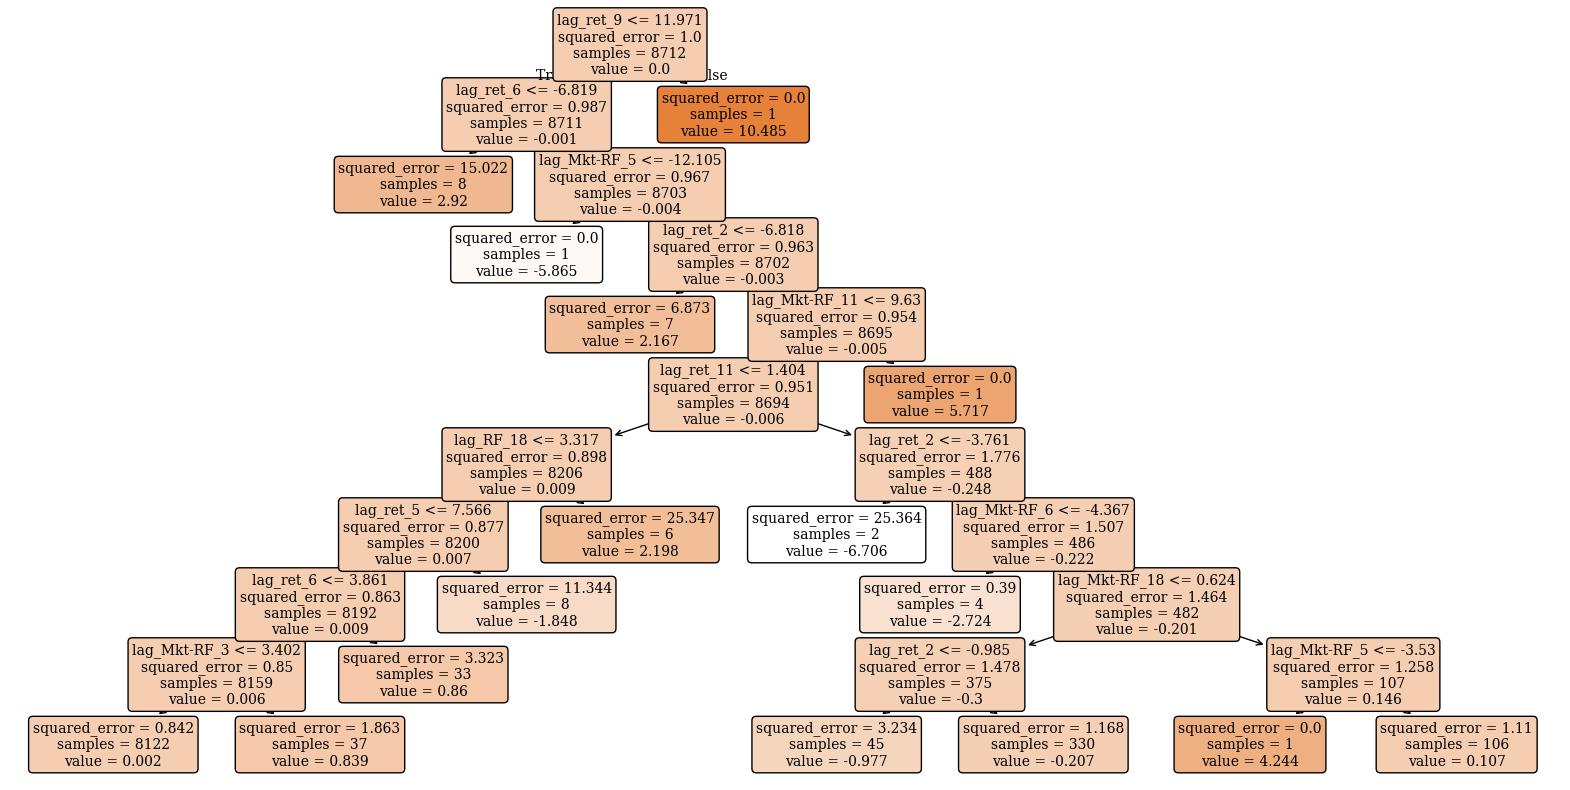

In [ ]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    final_dt,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


In [ ]:
print(pd.Series(
    final_dt.feature_importances_,
    index=feature_cols
))

predicted_egarch_variance    0.000000
dow_0                        0.000000
dow_1                        0.000000
dow_2                        0.000000
dow_3                        0.000000
dow_4                        0.000000
dom_0                        0.000000
dom_1                        0.000000
dom_2                        0.000000
dom_3                        0.000000
dom_4                        0.000000
lag_ret_2                    0.241391
lag_Mkt-RF_2                 0.000000
lag_RF_2                     0.000000
lag_ret_3                    0.000000
lag_Mkt-RF_3                 0.044403
lag_RF_3                     0.000000
lag_ret_5                    0.047470
lag_Mkt-RF_5                 0.088339
lag_RF_5                     0.000000
lag_ret_6                    0.158938
lag_Mkt-RF_6                 0.043484
lag_RF_6                     0.000000
lag_ret_9                    0.189266
lag_Mkt-RF_9                 0.000000
lag_RF_9                     0.000000
lag_ret_11  

The machine learning model we deployed on our data is the Decision Tree because we aim to capture non linearity in the structure of the data. (we also tried a Neural network as shown in the appendix which should have theoretically performed better given the fact that the variance of our data is an integrated process as described in point9, however since the MSFE is worse we deem the DT better, this is due to the fact that the visual poor tracking of the ML and the visually appealing tracking of the ARMA show evidence that we face a WHITE NOISE, hence a CER but acting as an ARMA, more in point 16).
Firstly, we have conducted feature engineering and we tried to capture the calendar effect by creating a dummy for the days of the week with one hot encoding, and a dummy for the days of the month with binary encoding to spare space and avoid an increase in entropy (degree of disorder and complexity of a system). Subsequently we introduced lagged variables to capture the effect of memory and persistence in the data, the choice was grounded on the use of the significant lags in the SACF and SPACF. Lastly, standard scaling was applied exclusively to numerical variables and not categorical ones (dom, dow) to ensure comparability as well as to the target of the forecast.
Concerning the choice of the hyperparameters, namely the depth of the tree and the sampling in the limited window we fed into the machine we acted in accordance to the variance bias tradeoff. Indeed we avoided giving too much depth or too little in order to produce the bets forecast out of sample. The same rationale was applied to the sampling, the min number of samples needed to split a node, in order to avoid over or underfitting.

Q15


In [ ]:
fig_dt = go.Figure()

fig_dt.add_trace(go.Scatter(
    x=forecasts_final_dt.index,
    y=forecasts_final_dt['forecasts_final_dt'],
    mode='lines',
    name='Forecasts',
    line=dict(color='steelblue', width=3)
))

fig_dt.add_trace(go.Scatter(
    x=forecasts_final_dt.index,
    y=forecasts_final_dt['ret'],
    mode='lines',
    name='ret',
    line=dict(color='firebrick', width=0.5)
))

fig_dt.update_layout(
    title=dict(
        text=f'Decision Tree Predicted Ret',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),
    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False
    ),
    yaxis=dict(
        title='Returns',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False,
        zeroline=False,
    ),
    font=dict(
        family="Serif",
        size=20,
        color="black"
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    legend=dict(
        font=dict(size=18),
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='black',
        borderwidth=1
    ),
    margin=dict(t=80, l=60, r=60, b=60)
)

fig_dt.show()

In [ ]:
fig_dt = go.Figure()

fig_dt.add_trace(go.Scatter(
    x=forecasts_final_dt.index,
    y=forecasts_final_dt['forecasts_final_dt'],
    mode='lines',
    name='Forecasts',
    line=dict(color='steelblue', width=3)
))

fig_dt.add_trace(go.Scatter(
    x=forecasts_final_dt.index,
    y=forecasts_final_dt['ret'],
    mode='lines',
    name='ret',
    line=dict(color='firebrick', width=0.5)
))

fig_dt.add_trace(go.Scatter(
    x=forecasts_final_dt.index,
    y=oos_forecast_arma,
    mode='lines',
    name='ARMA ret',
    line=dict(color='green', width=0.5)
))

fig_dt.update_layout(
    title=dict(
        text=f'Decision Tree Predicted Ret',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),
    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False
    ),
    yaxis=dict(
        title='Returns',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False,
        zeroline=False,
    ),
    font=dict(
        family="Serif",
        size=20,
        color="black"
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    legend=dict(
        font=dict(size=18),
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='black',
        borderwidth=1
    ),
    margin=dict(t=80, l=60, r=60, b=60)
)

fig_dt.show()

The machine learning model we have

In [ ]:
print('The MSFE of ARMA is: '+str(MSFE_arma))
print('THE MSFE of DT is: '+str(MSFE_dt))

The MSFE of ARMA is: 3.6720917400885873
THE MSFE of DT is: 2.4904988831985015


Q16

APPENDIX EXTRA NEURAL NETWORK


In [ ]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (120,), (120, 50)],  # different architectures
    'alpha': [0.001, 0.01, 0.1],                       # L2 penalty
    'learning_rate_init': [0.01, 0.1],                 # initial learning rate
}
mlp_results = []

In [ ]:
for hidden_layer_sizes in mlp_param_grid["hidden_layer_sizes"]:
    for alpha in mlp_param_grid["alpha"]:
        for learning_rate_init in mlp_param_grid["learning_rate_init"]:
            fold_mses = []
            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
                #Prepare the various datasets
                X_train_fold, X_validation_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
                y_train_fold, y_validation_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

                #Scale correctly the features
                X_train_fold_mean = X_train_fold.mean()
                X_train_fold_std  = X_train_fold.std(ddof=0)
                X_train_fold_scaled = (X_train_fold - X_train_fold_mean) / X_train_fold_std
                X_validation_fold_scaled = (X_validation_fold - X_train_fold_mean) / X_train_fold_std

                #Scale correctly the target
                y_train_fold_mean = y_train_fold.mean()
                y_train_fold_std  = y_train_fold.std(ddof=0)
                y_train_fold_scaled = (y_train_fold - y_train_fold_mean) / y_train_fold_std
                y_validation_fold_scaled = (y_validation_fold - y_train_fold_mean) / y_train_fold_std

                #Train the model for combination of hyperparameters + fold
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                     max_iter=1000,
                                     learning_rate_init=learning_rate_init,
                                     alpha=alpha,
                                     random_state=42,
                                     early_stopping=True,           # turn on early stopping
                                     validation_fraction=0.1,       # 10% of *each* training fold used as internal val-set
                                     shuffle=False,
                                     n_iter_no_change=100,          # stop if no improvement in 100 epochs
                                     tol=1e-4)                     # “improvement” must exceed 1e-4 in the loss)
                model.fit(X_train_fold_scaled, y_train_fold_scaled)

                #Predict
                y_pred_scaled = model.predict(X_validation_fold_scaled)

                #Inverse-scale the predictions
                y_pred = y_pred_scaled * y_train_fold_std + y_train_fold_mean

                #Calculate the MSE for the fold
                fold_mses.append(mean_squared_error(y_validation_fold, y_pred)) #log epsilon squared

            #Average the MSE over folds
            avg_mse = np.mean(fold_mses)
            mlp_results.append({
                "model": "MLP",
                "hidden_layer_sizes": hidden_layer_sizes,
                "alpha": alpha,
                "learning_rate_init": learning_rate_init,
                "average mse across 5 folds": avg_mse
            })

mlp_results_df = pd.DataFrame(mlp_results)
best_mlp = mlp_results_df.loc[mlp_results_df["average mse across 5 folds"].idxmin()]
print("\nBest MLPRegressor hyperparameters:")
print(best_mlp)


Best MLPRegressor hyperparameters:
model                               MLP
hidden_layer_sizes            (120, 50)
alpha                               0.1
learning_rate_init                  0.1
average mse across 5 folds     4.298303
Name: 17, dtype: object


In [ ]:
start_idx_test = X_test_scaled.index[0]
end_idx_test   = X_test_scaled.index[-1]
df_ret_test= df_ret.loc[start_idx_test + 1 : end_idx_test]
print(f"  [   {start_idx_test + 1} . . . {end_idx_test}   ]")

  [   8713 . . . 10890   ]


In [ ]:
# Multi-Layer Perceptron Final Model
final_mlp = MLPRegressor(hidden_layer_sizes=best_mlp['hidden_layer_sizes'],
                         max_iter=1000,
                         learning_rate_init=best_mlp['learning_rate_init'],
                         alpha=best_mlp['alpha'],
                         random_state=42,
                         early_stopping=True,           # turn on early stopping
                         validation_fraction=0.1,       # 10% of *each* training fold used as internal val-set
                         shuffle=False,
                         n_iter_no_change=100,          # stop if no improvement in 100 epochs
                         tol=1e-4)

final_mlp.fit(X_train_val_scaled, y_train_val_scaled)
y_pred_mlp_test_scaled = final_mlp.predict(X_test_scaled)
y_pred_mlp_test = y_pred_mlp_test_scaled * y_train_val_std + y_train_val_mean

In [ ]:
forecasts_final_mlp= pd.DataFrame(y_pred_mlp_test)
forecasts_final_mlp= forecasts_final_mlp[0:2177]

In [ ]:
forecasts_final_mlp.rename(columns={0: 'forecasts_final_mlp'}, inplace=True)
forecasts_final_mlp = forecasts_final_mlp.join(df_ret_test.reset_index(drop=True))

In [ ]:
forecasts_final_mlp.set_index('ds', inplace=True)
forecasts_final_mlp['forecasts_final_mlp'].value_counts()

,count
forecasts_final_mlp,
0.124698,1
0.103777,1
0.112926,1
0.100645,1
0.123866,1
...,...
0.251136,1
0.139899,1
0.348733,1


In [ ]:
forecast_errors_final_mlp = forecasts_final_mlp['forecasts_final_mlp'] - forecasts_final_mlp['ret']

In [ ]:
fig_mlp = go.Figure()

fig_mlp.add_trace(go.Scatter(
    x=forecasts_final_mlp.index,
    y=forecasts_final_mlp['forecasts_final_mlp'],
    mode='lines',
    name='Forecasts (MLP)',
    line=dict(color='steelblue', width=3)
))

fig_mlp.add_trace(go.Scatter(
    x=forecasts_final_mlp.index,
    y=forecasts_final_mlp['ret'],
    mode='lines',
    name=r'$\epsilon^2$',
    line=dict(color='firebrick', width=0.5)
))

fig_mlp.update_layout(
    title=dict(
        text=f'Multi-Layer Perceptron Predicted Returns',
        x=0.5,
        font=dict(size=30, family='Serif', color='black')
    ),
    xaxis=dict(
        title='Date',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False
    ),
    yaxis=dict(
        title='Squared Residual / Variance',
        titlefont=dict(size=25),
        tickfont=dict(size=20),
        showgrid=False,
        zeroline=False,
    ),
    font=dict(
        family="Serif",
        size=20,
        color="black"
    ),

    plot_bgcolor='rgba(0,0,0,0)',

    paper_bgcolor='rgba(0,0,0,0)',

    legend=dict(
        font=dict(size=18),
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='black',
        borderwidth=1
    ),
    margin=dict(t=80, l=60, r=60, b=60)
)

fig_mlp.show()

In [ ]:
MSFE_mlp = np.mean(np.array(forecast_errors_final_mlp)**2)
MSFE_mlp

np.float64(2.5354868372443407)